# data augmentation

### 1. Import Statements and Initial Setup

In [1]:
import os
import torch
import spintorch
import spintorch.geom
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from spintorch.utils import tic, toc, stat_cuda
from spintorch.plot import wave_integrated, wave_snapshot
from numpy import pi
from spintorch.data import DataGenerate 
import warnings
warnings.filterwarnings("ignore", message=".*Casting complex values to real.*")
from torch.optim.lr_scheduler import StepLR
%matplotlib inline

/Users/yifeige/anaconda3/envs/ML_env_mini/lib/python3.9/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1699448801785/work/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


### 2. Parameters

In [2]:
# Simulation Parameters
dx = 50e-9      # discretization (m)
dy = 50e-9      # discretization (m)
dz = 20e-9      # discretization (m)
nx = 160        # size x (cells)
ny = 100        # size y (cells)

Ms = 140e3      # saturation magnetization (A/m)
B0 = 60e-3      # bias field (T)
B0_theta = 0      # Angle of bias field in radian, e.g., pi/4
Bt = 1e-3       # excitation field amplitude (T)

dt = 20e-12     # timestep (s)
f1 = 4e9        # source frequency (Hz)
timesteps = 3920 # number of timesteps for wave propagation

### 3. Directory Setup

In [3]:
# Directories
basedir = '0703/'
savedir = 'models/' + basedir
if not os.path.isdir(savedir):
    os.makedirs(savedir)

# Create directories for different training stages
plotdir_AB = basedir +'plots_AB/'
if not os.path.isdir(plotdir_AB):
    os.makedirs(plotdir_AB)

plotdir_ABB = basedir +'plots_ABB/'
if not os.path.isdir(plotdir_ABB):
    os.makedirs(plotdir_ABB)
    
plotdir_AABB = basedir +'plots_AABB/'
if not os.path.isdir(plotdir_AABB):
    os.makedirs(plotdir_AABB) 

### 4. Geometry 

Running on cpu


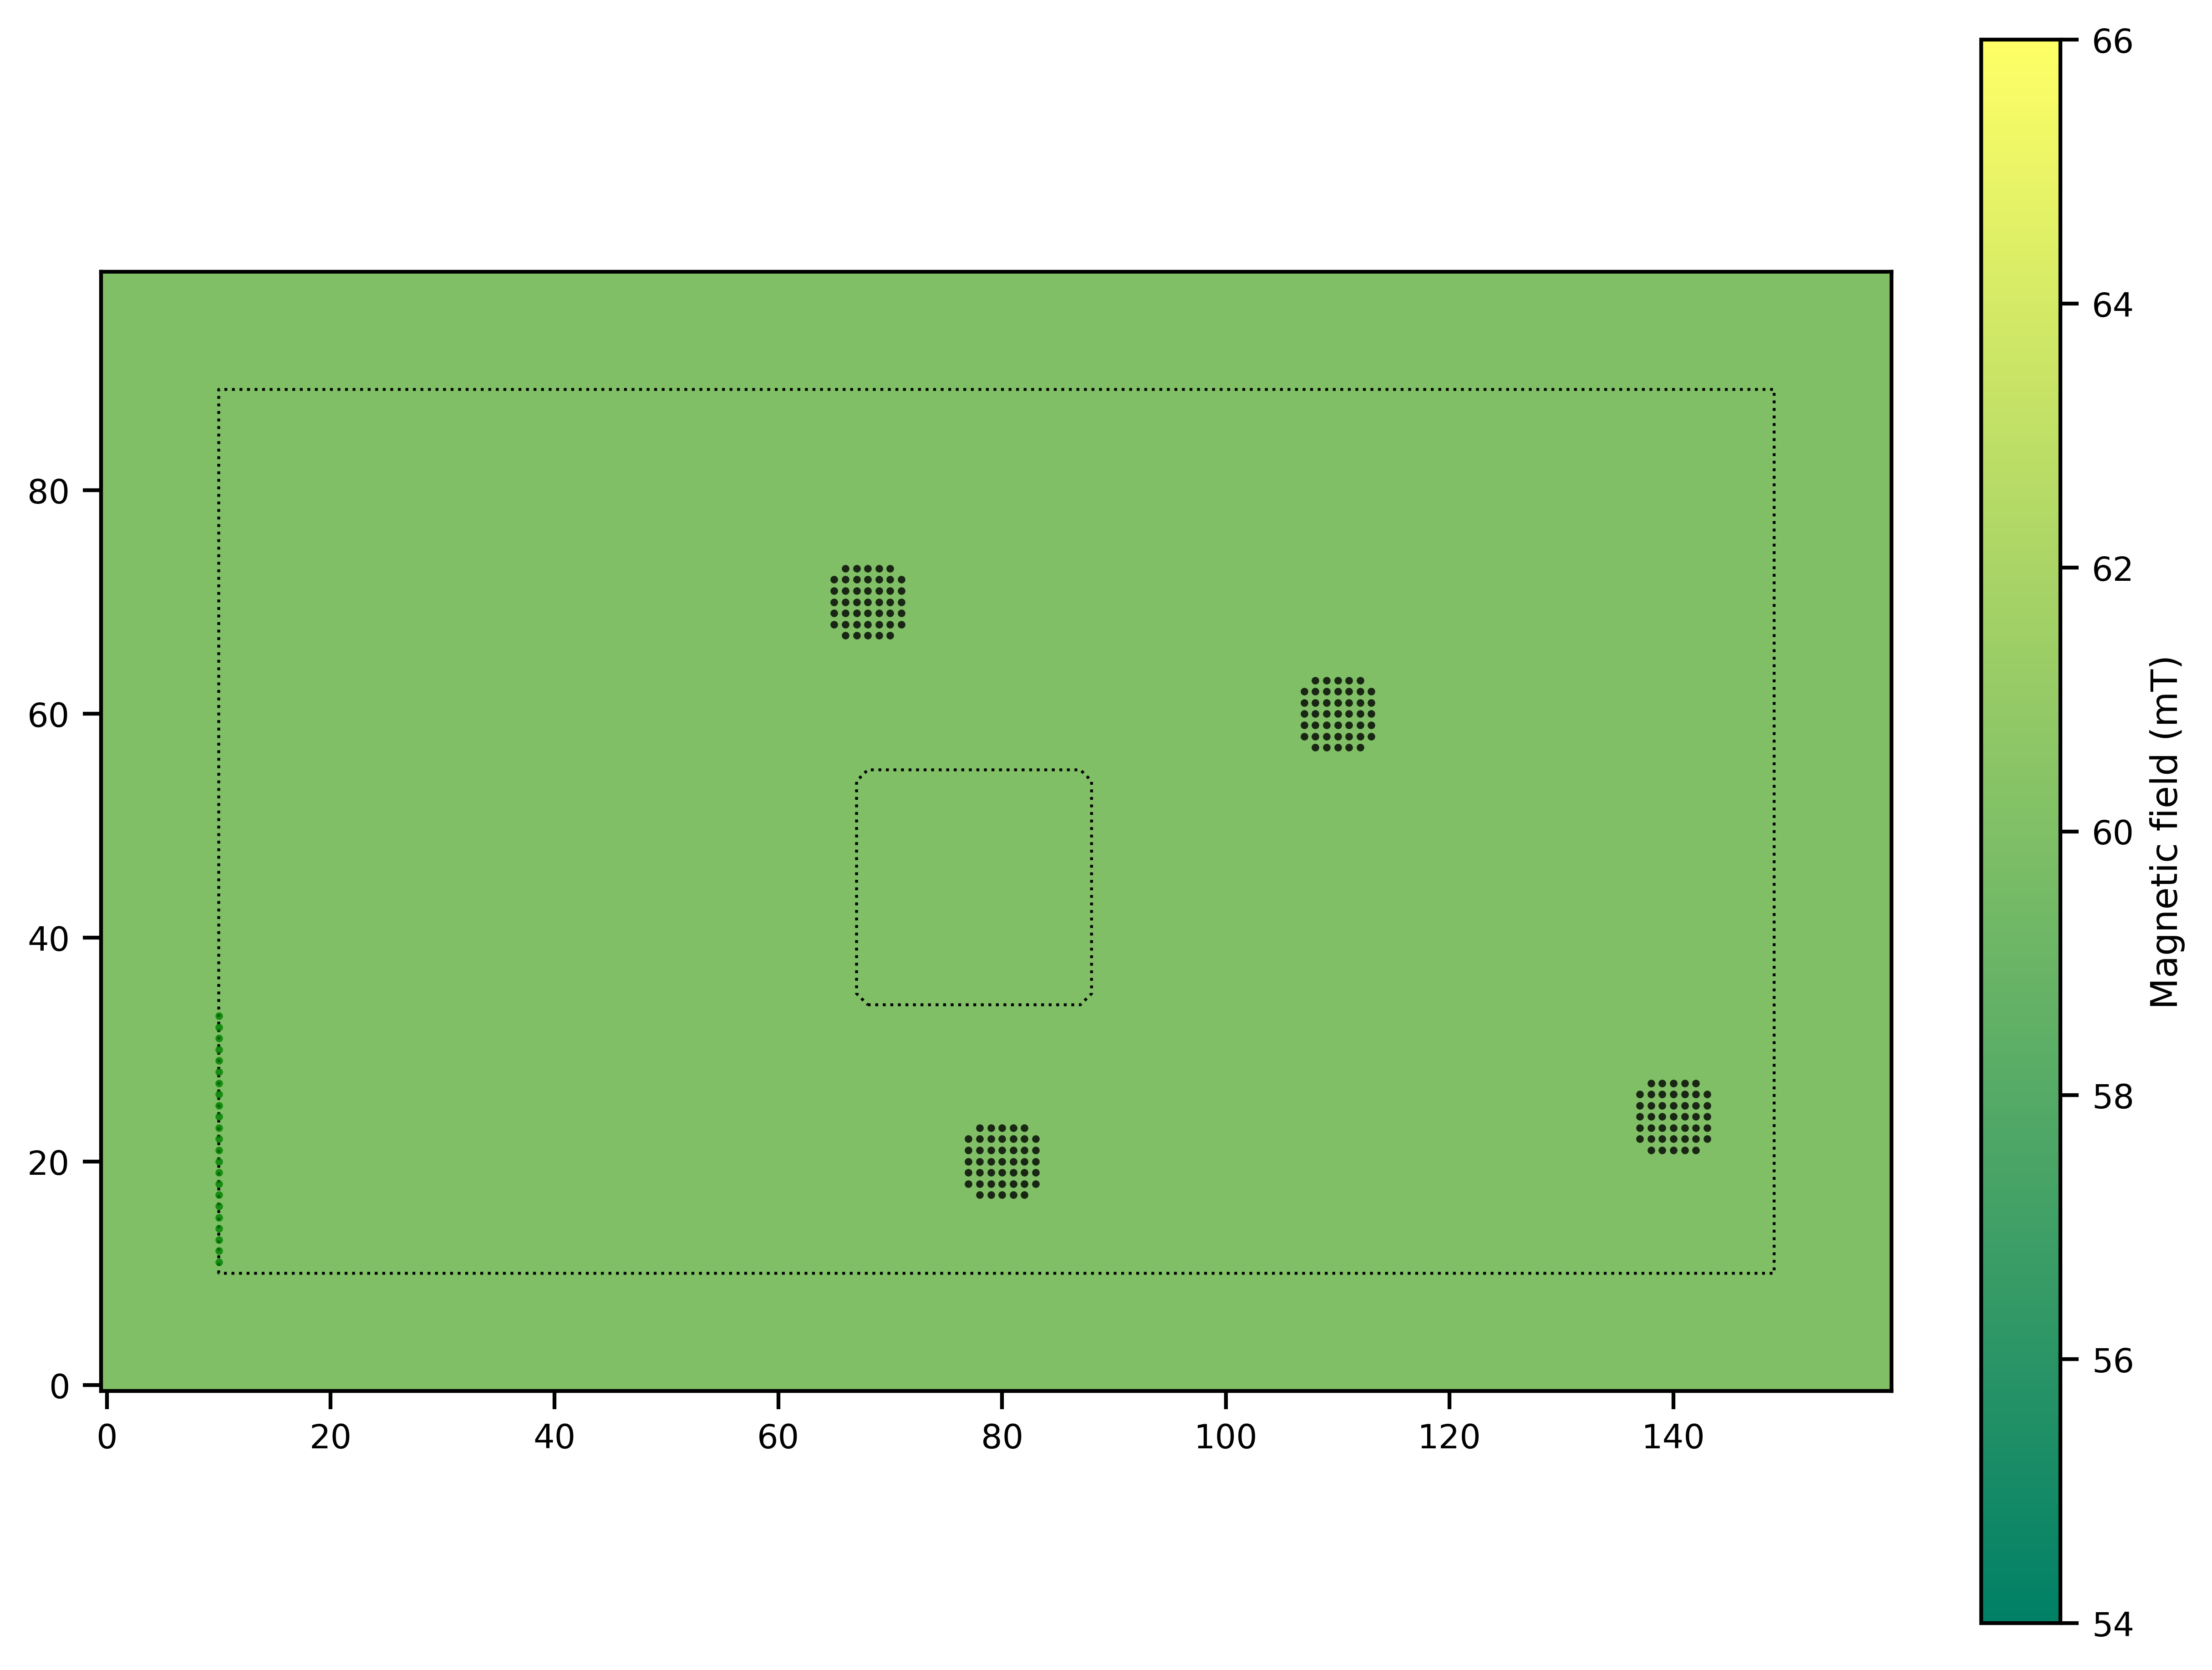

In [4]:
# Device Setup
dev = torch.device('cpu')  # 'cuda' or 'cpu'
print('Running on', dev)
### Here are three geometry modules initialized, just uncomment one of them to try:
Ms_CoPt = 723e3 # saturation magnetization of the nanomagnets (A/m)

r0_x, r0_y, dr, dm, z_off = 10, 10, 4, 2, 10  # starting pos, period, magnet size, z distance
rx, ry = 35,20

rho = torch.zeros((rx, ry))  # Design parameter array

## Define your mask here

mask = np.zeros((nx,ny))+0.25
###### only right with absorbing boundary
# right Vertical
for i in range(88, 150):  # 假设ny是上限
    for j in range(10, ny-10):
        mask[i][j] = 1

# left Vertical
for i in range(10, 68):  # 假设ny是上限
    for j in range(10, ny-10):
        mask[i][j] = 1

# top Horizontal
for i in range(10, 130):
    for j in range(ny-45, ny-10):  # 假设nx是上限
        mask[i][j] = 1

# bottom horizontal
for i in range(10, 130):
    for j in range(10, ny-65):  # 假设nx是上限
        mask[i][j] = 1


# Apply the mask to the file
Msat = Ms*mask
Msat = Msat.astype(np.float32)
geom = spintorch.geom.WaveGeometryArray_Ms(rho, (nx, ny), (dx, dy, dz), Msat, B0, B0_theta, 
                                    r0_x, r0_y, dr, dm, z_off, rx, ry, Ms_CoPt,mask)

 
# Define the source and probes
src = spintorch.WaveLineSource(10, 11, 10, 33, dim=2)
probes = []
probe_positions = [
    # (80, 29, 4),
    (80, 20, 4),
    # (80, 19, 4),
    # (80, 14, 4),
    # probes at the bottom path
    (68, 70, 4),
    # (68, 65, 4),
    # # probes at the top path
    (110, 60, 4),
    # (120, 43, 4),
    # # probes at the right path
    (140, 24, 4)
]

probes = [spintorch.WaveIntensityProbeDisk(*pos) for pos in probe_positions]

model = spintorch.MMSolver(geom, dt, [src], probes)

model.to(dev)   # sending model to GPU/CPU


'''Define optimizer and lossfunction'''
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
with torch.no_grad():
            spintorch.plot.geometry(model)

### 5. Source Signal and Output Goal

In [5]:
import random

def generate_random_freq_pairs(num_pairs):
    freq_pairs = []
    for _ in range(num_pairs):
        f_B = random.uniform(3.45e9, 3.55e9)  # f_B 在 3.4 GHz 到 3.5 GHz 之间
        delta_f = 0.5e9 
        f_A = f_B + delta_f
        freq_pairs.append((f_A, f_B))
    return freq_pairs

# 生成指定数量的随机频率对
num_pairs = 50  # 生成5对随机频率对
random_freq_pairs = generate_random_freq_pairs(num_pairs)
# print(random_freq_pairs)
# f_A 3.8~4.0 GHz
# f_B 3.4~3.5 GHz  

In [6]:
# freq_pairs = [ (3.3e9, 3.5e9), (3.5e9, 3.5e9), (3.7e9, 3.5e9), (3.8e9, 3.5e9), (4.0e9, 3.5e9), (4.2e9, 3.5e9)]
# 从 freq_pairs 提取第一列的所有值
f_A_list = [pair[0] for pair in random_freq_pairs]
f_B_list = [pair[1] for pair in random_freq_pairs]
# 找出最小值
min_fA= min(f_A_list)
min_fB= min(f_B_list)
# 计算 10e9 / min_value 并保留两位小数
tao_A = 3.0e-9
tao_B = 3.4e-9
print('tao_A:', tao_A, 'tao_B:', tao_B) 

tao_A: 3e-09 tao_B: 3.4e-09


In [7]:
import numpy as np

# 示例 SNR 值
snr = np.array([5, 10, 15, 20, 25, 30])
result = 10 ** (-snr / 20)
print(result)

[0.56234133 0.31622777 0.17782794 0.1        0.05623413 0.03162278]


In [8]:
import os
import torch
import numpy as np

def generate_sine_signal(frequency, amplitude, duration, dt, device):
    t = torch.arange(0, duration, dt, device=device)
    signal = amplitude * torch.sin(2 * np.pi * frequency * t)
    return signal

def calculate_power(signal):
    return torch.mean(signal**2)

def calculate_noise_power(signal_power, snr_db):
    snr_linear = 10**(snr_db / 10)
    noise_power = signal_power / snr_linear
    return noise_power

def add_noise(signal, snr_db, device):
    signal_power = calculate_power(signal)
    noise_power = calculate_noise_power(signal_power, snr_db)
    noise = torch.sqrt(noise_power) * torch.randn(signal.size(), device=device)
    noisy_signal = signal + noise
    return noisy_signal

def generate_sequences(freq_pairs, num_periods, tao_A, tao_B, Bt, dt, repeat_count1, repeat_count2, repeat_count3, snr_db, device='cpu'):
    raw_sequences = []

    # 遍历所有频率对生成原始序列
    for (f_A, f_B) in freq_pairs:
        T_A = 1 / f_A
        T_B = 1 / f_B
        
        A_duration = num_periods * T_A
        B_duration = num_periods * T_B
        
        middle_zero_duration_A = tao_A - A_duration
        middle_zero_duration_B = tao_B - B_duration

        A_signal = generate_sine_signal(f_A, Bt, A_duration, dt, device)
        B_signal = generate_sine_signal(f_B, Bt, B_duration, dt, device)
        
        middle_zero_A = torch.zeros(int(middle_zero_duration_A / dt), device=device)
        middle_zero_B = torch.zeros(int(middle_zero_duration_B / dt), device=device)
        
        pattern1 = torch.cat([A_signal, middle_zero_A, B_signal, middle_zero_A])
        pattern2 = torch.cat([A_signal, middle_zero_A, B_signal, middle_zero_B, B_signal, middle_zero_A])
        pattern3 = torch.cat([A_signal, middle_zero_A, A_signal, middle_zero_A, B_signal, middle_zero_B, B_signal, middle_zero_A])
        
        # 重复序列
        pattern1 = torch.cat([pattern1] * repeat_count1)
        pattern2 = torch.cat([pattern2] * repeat_count2)
        pattern3 = torch.cat([pattern3] * repeat_count3)
        raw_sequences.append((pattern1, pattern2, pattern3))

    # 确定最大长度
    max_len = max(max(len(seq) for seq in pattern) for pattern in raw_sequences)

    # 对所有信号进行补齐，并添加噪声
    sequences = []
    for pattern1, pattern2, pattern3 in raw_sequences:
        pattern1 = torch.cat([pattern1, torch.zeros(max_len - len(pattern1), device=device)])
        pattern2 = torch.cat([pattern2, torch.zeros(max_len - len(pattern2), device=device)])
        pattern3 = torch.cat([pattern3, torch.zeros(max_len - len(pattern3), device=device)])

        pattern1_noisy = add_noise(pattern1, snr_db, device)
        pattern2_noisy = add_noise(pattern2, snr_db, device)
        pattern3_noisy = add_noise(pattern3, snr_db, device)
        
        sequences.append((pattern1_noisy, pattern2_noisy, pattern3_noisy))

    return sequences

# 示例参数
num_periods = 10
Bt = 1e-3
dt = 20e-12
repeat_count1 = 12
repeat_count2 = 8
repeat_count3 = 6
device = 'cpu'


# 生成不同SNR的数据集
snr_values = [5, 10, 15, 20, 25, 30]
all_sequences = []

for snr in snr_values:
    sequences = generate_sequences(random_freq_pairs, num_periods, tao_A, tao_B, Bt, dt, repeat_count1, repeat_count2, repeat_count3, snr, device)
    all_sequences.append(sequences)
    print(f"Generated sequences with SNR: {snr} dB")

# 打印输出，检查序列长度和数据
for i, sequences_rdf in enumerate(all_sequences):
    snr = snr_values[i]
    print(f"\nSNR: {snr} dB")
    for j, (seq1, seq2, seq3) in enumerate(sequences_rdf):
        print(f"Sequence set {j+1}: Length of seq1: {len(seq1)}, Length of seq2: {len(seq2)}, Length of seq3: {len(seq3)}")


Generated sequences with SNR: 5 dB
Generated sequences with SNR: 10 dB
Generated sequences with SNR: 15 dB
Generated sequences with SNR: 20 dB
Generated sequences with SNR: 25 dB
Generated sequences with SNR: 30 dB

SNR: 5 dB
Sequence set 1: Length of seq1: 3912, Length of seq2: 3912, Length of seq3: 3912
Sequence set 2: Length of seq1: 3912, Length of seq2: 3912, Length of seq3: 3912
Sequence set 3: Length of seq1: 3912, Length of seq2: 3912, Length of seq3: 3912
Sequence set 4: Length of seq1: 3912, Length of seq2: 3912, Length of seq3: 3912
Sequence set 5: Length of seq1: 3912, Length of seq2: 3912, Length of seq3: 3912
Sequence set 6: Length of seq1: 3912, Length of seq2: 3912, Length of seq3: 3912
Sequence set 7: Length of seq1: 3912, Length of seq2: 3912, Length of seq3: 3912
Sequence set 8: Length of seq1: 3912, Length of seq2: 3912, Length of seq3: 3912
Sequence set 9: Length of seq1: 3912, Length of seq2: 3912, Length of seq3: 3912
Sequence set 10: Length of seq1: 3912, Length

In [9]:
# save the data
import os
import torch
torch.save(all_sequences, '0703/sequences.pt')

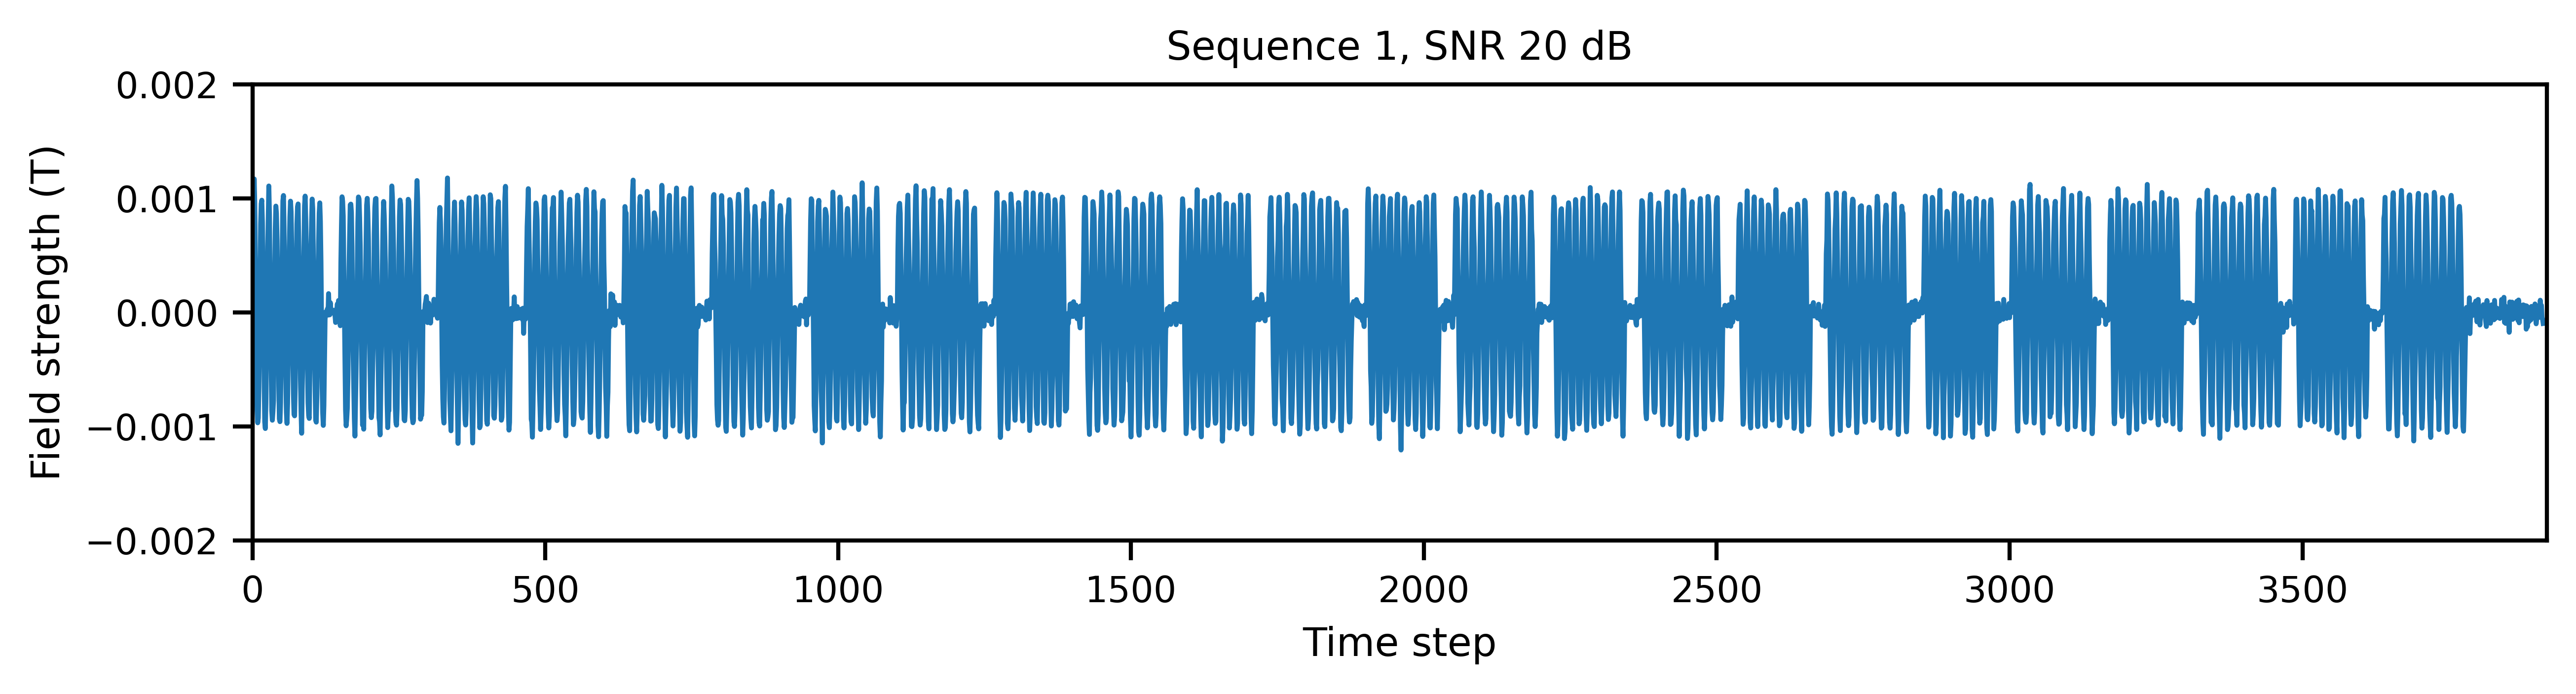

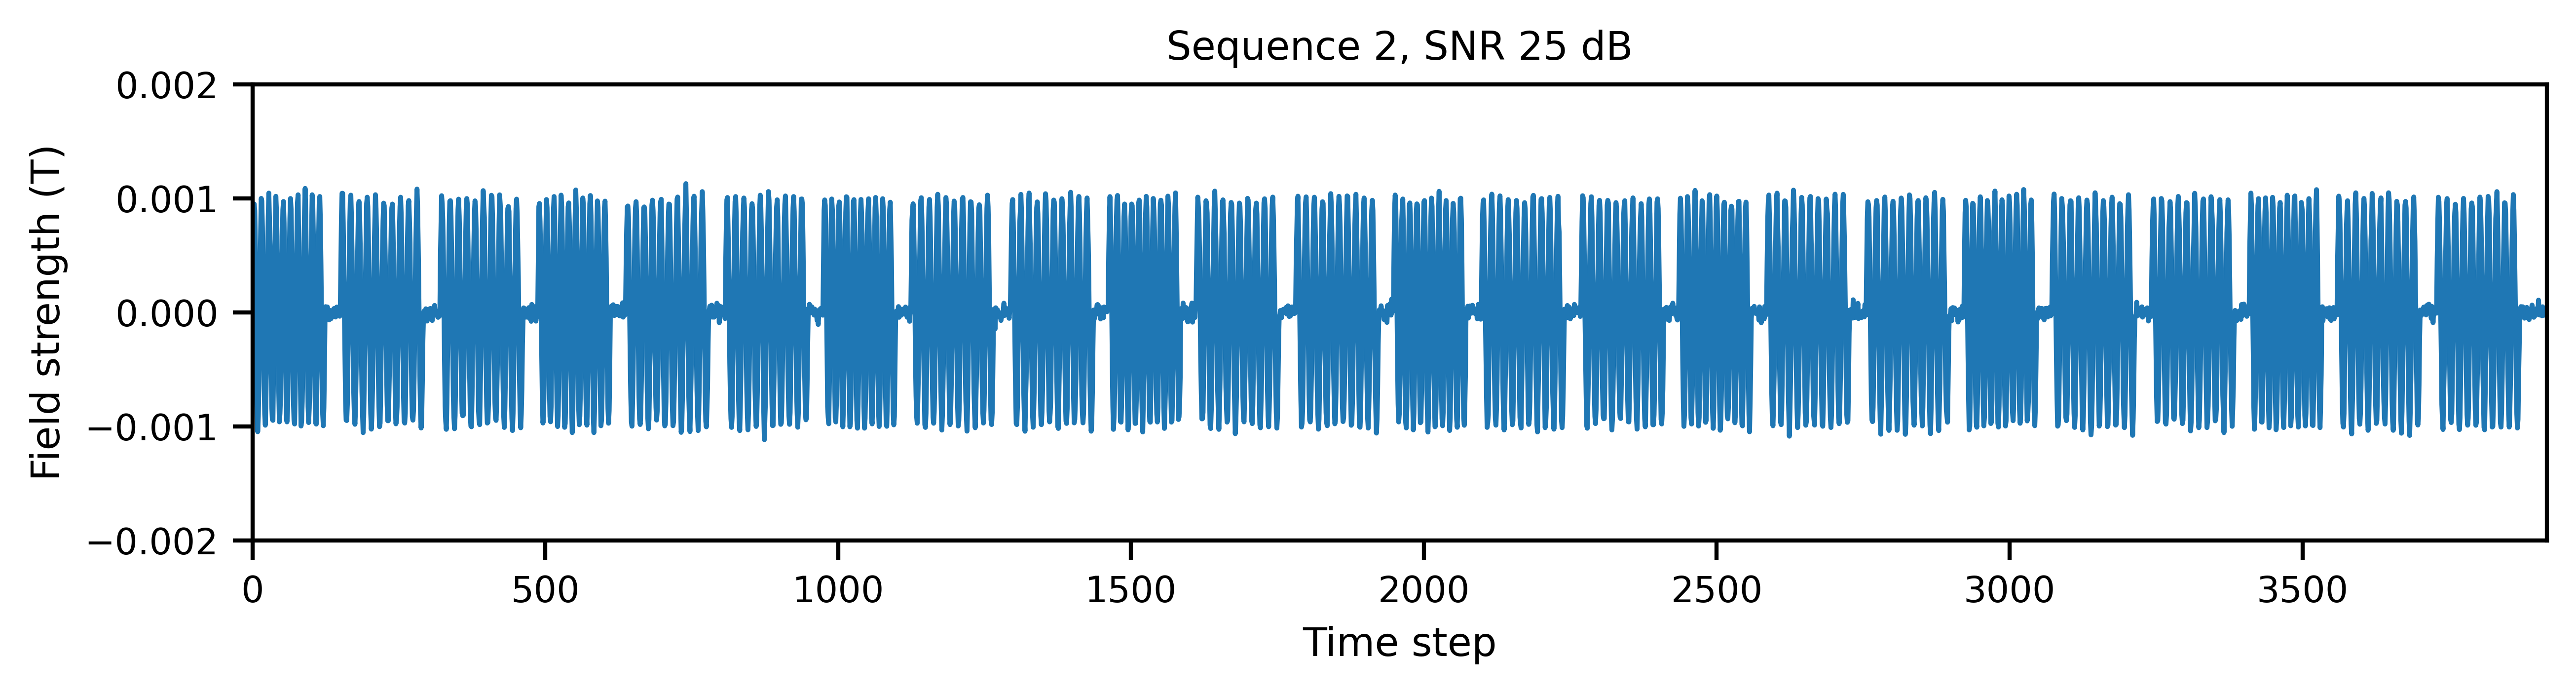

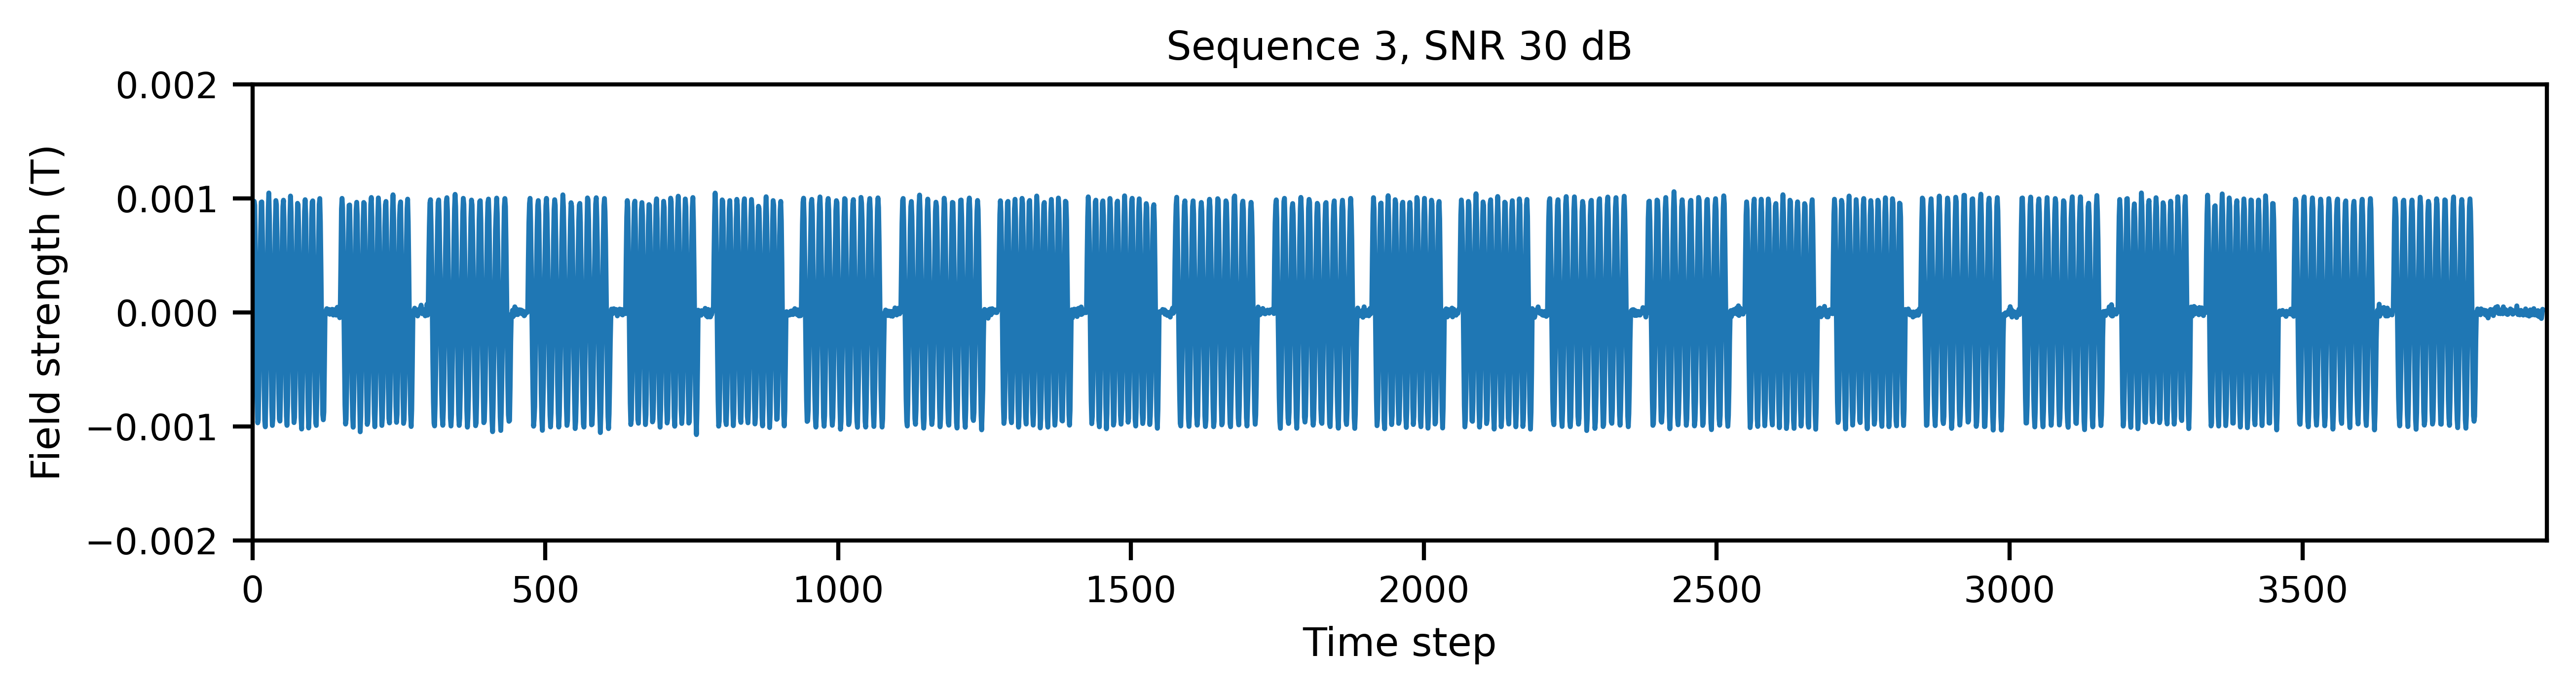

In [22]:
import matplotlib.pyplot as plt
# plot the sequence
def plot_sequence(seq, title):
    plt.figure(figsize=(10, 2))
    plt.plot(seq.cpu().numpy())
    plt.title(title)
    plt.ylim(-0.002, 0.002)
    plt.xlim(0, len(seq)+5)
    plt.xlabel('Time step')
    plt.ylabel('Field strength (T)')
    plt.show()

plot_sequence(all_sequences[3][0][0], 'Sequence 1, SNR 20 dB')
plot_sequence(all_sequences[4][0][1], 'Sequence 2, SNR 25 dB')
plot_sequence(all_sequences[5][0][2], 'Sequence 3, SNR 30 dB')

### 6. Loss Function for Delay Line Functionality

In [13]:

def delay_line_loss(output, target_index):
    target_value = output[:,target_index]
    loss = output.sum(dim=1)/target_value-1
    return (loss.sum()/loss.size()[0]).log10()

### 10. Checkpoint Loading(Setting to -1 means not loading)

In [14]:
# Load checkpoint
epoch = epoch_init = 2  # select previous checkpoint (-1 = don't use checkpoint)
if epoch_init >= 0:
    checkpoint = torch.load('models/' + '0702/' + 'model_e%d.pt' % epoch_init)
    epoch = checkpoint['epoch']
    loss_iter = checkpoint['loss_iter']
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
else:
    loss_iter = []


## 1: AB delay line training

In [21]:
seq1  = seq1.unsqueeze(0).unsqueeze(2)
seq2  = seq2.unsqueeze(0).unsqueeze(2)
seq3  = seq3.unsqueeze(0).unsqueeze(2)

In [22]:
'''Train the network'''
tic()
INPUTS = seq1.to(dev)
OUTPUTS = torch.tensor([0,1,2,3]).to(dev)
model.retain_history = True
epochs = 4
mz_history_AB = []
mz_squared_AB = []
mz_history_ABB = []
mz_squared_ABB = []
mz_history_AABB = []
mz_squared_AABB = []

for epoch in range(epoch_init+1, epochs):
    optimizer.zero_grad()
    u = model(INPUTS).sum(dim=1) # integral!!!!!
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(name)
    
    spintorch.plot.plot_output(u[0,], OUTPUTS[0]+1, epoch, plotdir_AB)
    loss = delay_line_loss(u, OUTPUTS)
    loss_iter.append(loss.item())  # store loss values
    spintorch.plot.plot_loss(loss_iter, plotdir_AB)
    # stat_cuda('after forward')
    loss.backward()
    optimizer.step()
    # stat_cuda('after backward')
    print("Epoch finished: %d -- Loss: %.6f" % (epoch, loss))
    toc()   

    '''Save model checkpoint'''
    torch.save({
                'epoch': epoch,
                'loss_iter': loss_iter,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
                }, savedir + 'model_e%d.pt' % (epoch))
    
    '''Plot spin-wave propagation'''
    if model.retain_history:
        with torch.no_grad():
            # spintorch.plot.geometry(model, epoch = epoch, plotdir = plotdir_AB)
            mz = torch.stack(model.m_history, 1)[0,:,2,] - model.m0[0,2,].unsqueeze(0).cpu()
            mz_squared = mz ** 2
            mz_history_AB.append(mz.clone())
            mz_squared_AB.append(mz_squared.clone())
            # wave_snapshot(model, mz[timesteps-1], plotdir + f'snapshot_time{timesteps}_epoch{epoch}.png', r"$m_z$")
            # wave_snapshot(model, mz[int(timesteps/2)-1], plotdir + f'snapshot_time{int(timesteps/2)}_epoch{epoch}.png', r"$m_z$")
            wave_integrated(model, mz, plotdir_AB + f'integrated_epoch{epoch}.png')
            # 改变模型的输入为seq2并获得新的 mz
            u_2 = model(seq2).sum(dim=1)
            mz_2 = torch.stack(model.m_history, 1)[0, :, 2, ] - model.m0[0, 2, ].unsqueeze(0).cpu()
            mz_squared_2 = mz_2 ** 2
            mz_history_ABB.append(mz_2.clone())
            mz_squared_ABB.append(mz_squared_2.clone())
            # 可视化或存储 mz_2
            wave_integrated(model, mz_2, plotdir_ABB + f'new_integrated_epoch{epoch}.png')
            # 改变模型的输入为seq3并获得新的 mz
            u_3 = model(seq3).sum(dim=1)
            mz_3 = torch.stack(model.m_history, 1)[0, :, 2, ] - model.m0[0, 2, ].unsqueeze(0).cpu()
            mz_squared_3 = mz_3 ** 2
            mz_history_AABB.append(mz_3.clone())
            mz_squared_AABB.append(mz_squared_3.clone())
            # 可视化或存储 mz_3
            wave_integrated(model, mz_3, plotdir_AABB + f'new_integrated_epoch{epoch}.png')
          


/Users/yifeige/anaconda3/envs/ML_env_mini/lib/python3.9/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/Users/yifeige/anaconda3/envs/ML_env_mini/lib/python3.9/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


geom.rho
Epoch finished: 0 -- Loss: 2.327545
Elapsed time 242.11 s, (dt = 242.11 s)
geom.rho
Epoch finished: 1 -- Loss: 1.914351
Elapsed time 627.57 s, (dt = 385.46 s)
geom.rho
Epoch finished: 2 -- Loss: 1.914433
Elapsed time 1005.35 s, (dt = 377.78 s)
geom.rho
Epoch finished: 3 -- Loss: 1.277166
Elapsed time 1380.00 s, (dt = 374.65 s)


In [18]:
len(all_sequences[0][0])

3

In [21]:
import torch
import os


# 假设您已经生成了 `all_sequences` 列表，其中包含不同 SNR 的数据集。
# 假设模型、设备和保存目录已经定义。
device = 'cpu'

# 确保保存主目录存在
main_savedir = 'snr_results/'
os.makedirs(main_savedir, exist_ok=True)

# 定义一个函数来处理模型推理和保存结果
def process_and_save(model, seq, label, savedir, seq_id):
    with torch.no_grad():
        model.retain_history = True
        seq = seq.unsqueeze(0).unsqueeze(2).to(device)
        u = model(seq.to(device)).sum(dim=1)
        
        if model.m_history:  # 确保m_history不为空
            mz = torch.stack(model.m_history, 1)[0, :, 2, ] - model.m0[0, 2, ].unsqueeze(0).cpu()
            mz_squared = mz ** 2

            # 保存 mz_squared
            torch.save(mz_squared, os.path.join(savedir, f'mz_squared_seq_{seq_id}_label_{label}.pt'))
            wave_integrated(model, mz, os.path.join(savedir, f'integrated_seq_{seq_id}_label_{label}.png'))
            print(f'Saved mz_squared for sequence {seq_id} with label {label}')

# 遍历所有的 SNR 值
for snr_index, snr in enumerate(snr_values):
    sequences_snr = all_sequences[snr_index]
    snr_savedir = os.path.join(main_savedir, f'{snr}dB_results/')
    plotdir = os.path.join(snr_savedir, 'plots/')
    os.makedirs(snr_savedir, exist_ok=True)
    os.makedirs(plotdir, exist_ok=True)
    
    # 只处理每个 SNR 数据集中的第一组数据，并标注周期长度
    seq1, seq2, seq3 = sequences_snr[0]
    seq_id = f'snr_{snr}_seq_0'
    
    # AB 模式
    process_and_save(model, seq1, label=2, savedir=snr_savedir, seq_id=f'{seq_id}_AB')
    
    # ABB 模式
    process_and_save(model, seq2, label=3, savedir=snr_savedir, seq_id=f'{seq_id}_ABB')
    
    # AABB 模式
    process_and_save(model, seq3, label=4, savedir=snr_savedir, seq_id=f'{seq_id}_AABB')


/Users/yifeige/anaconda3/envs/ML_env_mini/lib/python3.9/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/Users/yifeige/anaconda3/envs/ML_env_mini/lib/python3.9/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Saved mz_squared for sequence snr_5_seq_0_AB with label 2
Saved mz_squared for sequence snr_5_seq_0_ABB with label 3
Saved mz_squared for sequence snr_5_seq_0_AABB with label 4
Saved mz_squared for sequence snr_10_seq_0_AB with label 2
Saved mz_squared for sequence snr_10_seq_0_ABB with label 3
Saved mz_squared for sequence snr_10_seq_0_AABB with label 4
Saved mz_squared for sequence snr_15_seq_0_AB with label 2
Saved mz_squared for sequence snr_15_seq_0_ABB with label 3
Saved mz_squared for sequence snr_15_seq_0_AABB with label 4
Saved mz_squared for sequence snr_20_seq_0_AB with label 2
Saved mz_squared for sequence snr_20_seq_0_ABB with label 3
Saved mz_squared for sequence snr_20_seq_0_AABB with label 4
Saved mz_squared for sequence snr_25_seq_0_AB with label 2
Saved mz_squared for sequence snr_25_seq_0_ABB with label 3
Saved mz_squared for sequence snr_25_seq_0_AABB with label 4
Saved mz_squared for sequence snr_30_seq_0_AB with label 2
Saved mz_squared for sequence snr_30_seq_0_A

In [45]:
import torch
import os

# 假设您已经生成了 `sequences` 列表，其中包含不同 SNR 的数据集。
# 此处我们只处理 SNR 为 20 dB 的数据集。
snr_20_db_index = snr_values.index(20)
sequences_20_db = all_sequences[snr_20_db_index]

# 假设模型、设备和保存目录已经定义。
device = 'cpu'
savedir = '20dB_results/'
plotdir = '20dB_results/plots/'
# 确保保存目录存在
os.makedirs(savedir, exist_ok=True)
os.makedirs(plotdir, exist_ok=True)
# 定义一个函数来处理模型推理和保存结果
def process_and_save(model, seq, label, savedir, seq_id):
    with torch.no_grad():
        model.retain_history = True
        seq = seq.unsqueeze(0).unsqueeze(2).to(device)
        u = model(seq.to(device)).sum(dim=1)
        
        if model.m_history:  # 确保m_history不为空
            mz = torch.stack(model.m_history, 1)[0, :, 2, ] - model.m0[0, 2, ].unsqueeze(0).cpu()
            mz_squared = mz ** 2

            # 保存 mz_squared
            torch.save(mz_squared, os.path.join(savedir, f'mz_squared_seq_{seq_id}_label_{label}.pt'))
            wave_integrated(model, mz, plotdir + f'integrated_seq_{seq_id}_label_{label}.png')
            print(f'Saved mz_squared for sequence {seq_id} with label {label}')

# 处理每条数据，并标注周期长度
for seq_id, (seq1, seq2, seq3) in enumerate(sequences_20_db):
    # AB 模式
    process_and_save(model, seq1, label=2, savedir=savedir, seq_id=f'{seq_id}_AB')
    
    # ABB 模式
    process_and_save(model, seq2, label=3, savedir=savedir, seq_id=f'{seq_id}_ABB')
    
    # AABB 模式
    process_and_save(model, seq3, label=4, savedir=savedir, seq_id=f'{seq_id}_AABB')


/Users/yifeige/anaconda3/envs/ML_env_mini/lib/python3.9/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/Users/yifeige/anaconda3/envs/ML_env_mini/lib/python3.9/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Saved mz_squared for sequence 0_AB with label 2
Saved mz_squared for sequence 0_ABB with label 3
Saved mz_squared for sequence 0_AABB with label 4
Saved mz_squared for sequence 1_AB with label 2
Saved mz_squared for sequence 1_ABB with label 3
Saved mz_squared for sequence 1_AABB with label 4
Saved mz_squared for sequence 2_AB with label 2
Saved mz_squared for sequence 2_ABB with label 3
Saved mz_squared for sequence 2_AABB with label 4
Saved mz_squared for sequence 3_AB with label 2
Saved mz_squared for sequence 3_ABB with label 3
Saved mz_squared for sequence 3_AABB with label 4
Saved mz_squared for sequence 4_AB with label 2
Saved mz_squared for sequence 4_ABB with label 3
Saved mz_squared for sequence 4_AABB with label 4
Saved mz_squared for sequence 5_AB with label 2
Saved mz_squared for sequence 5_ABB with label 3
Saved mz_squared for sequence 5_AABB with label 4
Saved mz_squared for sequence 6_AB with label 2
Saved mz_squared for sequence 6_ABB with label 3
Saved mz_squared for 

In [67]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torch
import numpy as np
import matplotlib.pyplot as plt

def plot_power_in_region_over_time(mz_squared, x_start, x_end, y_start, y_end, dt, title, ax, y_max, dpi=300):
    """
    计算给定区域的 m_z 值的平方和，并绘制其随时间变化的图表
    
    参数:
    - mz_squared: 输入的 m_z 张量，形状为 [timesteps, height, width]
    - x_start, x_end: 区域的 x 轴起始和结束索引
    - y_start, y_end: 区域的 y 轴起始和结束索引
    - dt: 时间步长 (s)
    - dpi: 图像的分辨率 (默认 300)
    """
    
    # 提取指定区域的值
    region_values = mz_squared[:, x_start:x_end, y_start:y_end]
    
    # 计算区域内所有时间序列的和
    intensity = region_values.sum(dim=(1, 2))
    
    # 将 PyTorch 张量转换为 NumPy 数组
    intensity_np = intensity.numpy()
    
    # 生成时间步长序列
    time_steps = np.arange(len(intensity_np)) * dt
    
    # 动态生成标题
    
    xlabel = 'Time (s)'
    ylabel = r'$m_{z}$'

    ax.plot(time_steps, intensity_np, linewidth=2)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.grid(True)
    ax.set_ylim(-0.001, y_max)
    return intensity_np

 


In [57]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def perform_fft_on_mz(intensity , t0):
    """
    对 mz 张量去掉前一部分几乎为零的长度后，做傅立叶变换 (FFT)
    
    参数:
    - mz_squared: 输入的 m_z 值的平方和张量，形状为 [timesteps, height, width]
    - threshold: 判断前部分是否为零的阈值 (默认 1e-6)
    - t0: 去掉前面几乎为零的部分的长度
    
    返回:
    - freqs: 频率数组
    - fft_values: 对应频率的 FFT 值
    """
   
    # 去掉前面几乎为零的部分
    trimmed_mz = intensity[t0:]
    
    # 对每个位置的时间序列做傅里叶变换
    fft_values = torch.fft.fft(trimmed_mz)
    
    # 计算频率
    num_timesteps = trimmed_mz.shape[0]
    dt = 20e-12 # 你可以根据实际的时间步长来设置
    freqs = torch.fft.fftfreq(num_timesteps, dt)
    
    return freqs.cpu().numpy(), fft_values.cpu().numpy()





In [74]:
def plot_fft_spectrum(freqs, fft_values, xmin, xmax, title, ax):
    """
    绘制傅立叶变换的频谱图, 并返回前 5 个频率的幅度
    
    参数:
    - freqs: 频率数组
    - fft_values: 对应频率的 FFT 值
    """
    # 计算幅度
    magnitudes = np.abs(fft_values)
    
    # 只保留正频率部分
    positive_freqs = freqs[freqs > 0]
    positive_magnitudes = magnitudes[freqs > 0]

    indices = np.argsort(positive_magnitudes)[-5:][::-1]  # 从大到小排序并取前 n 个
    top_frequencies = positive_freqs[indices]
    top_magnitudes = positive_magnitudes[indices]
    ax.plot(positive_freqs, positive_magnitudes, linewidth=2)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylim(-0.1,3)
    ax.set_xlim(xmin, xmax)
    ax.set_ylabel('Magnitude')
    ax.grid(True)
    return top_frequencies, top_magnitudes

# title = 'FFT Spectrum of sequence AB (output)'
# plot_fft_spectrum(freqs, fft_values,title)


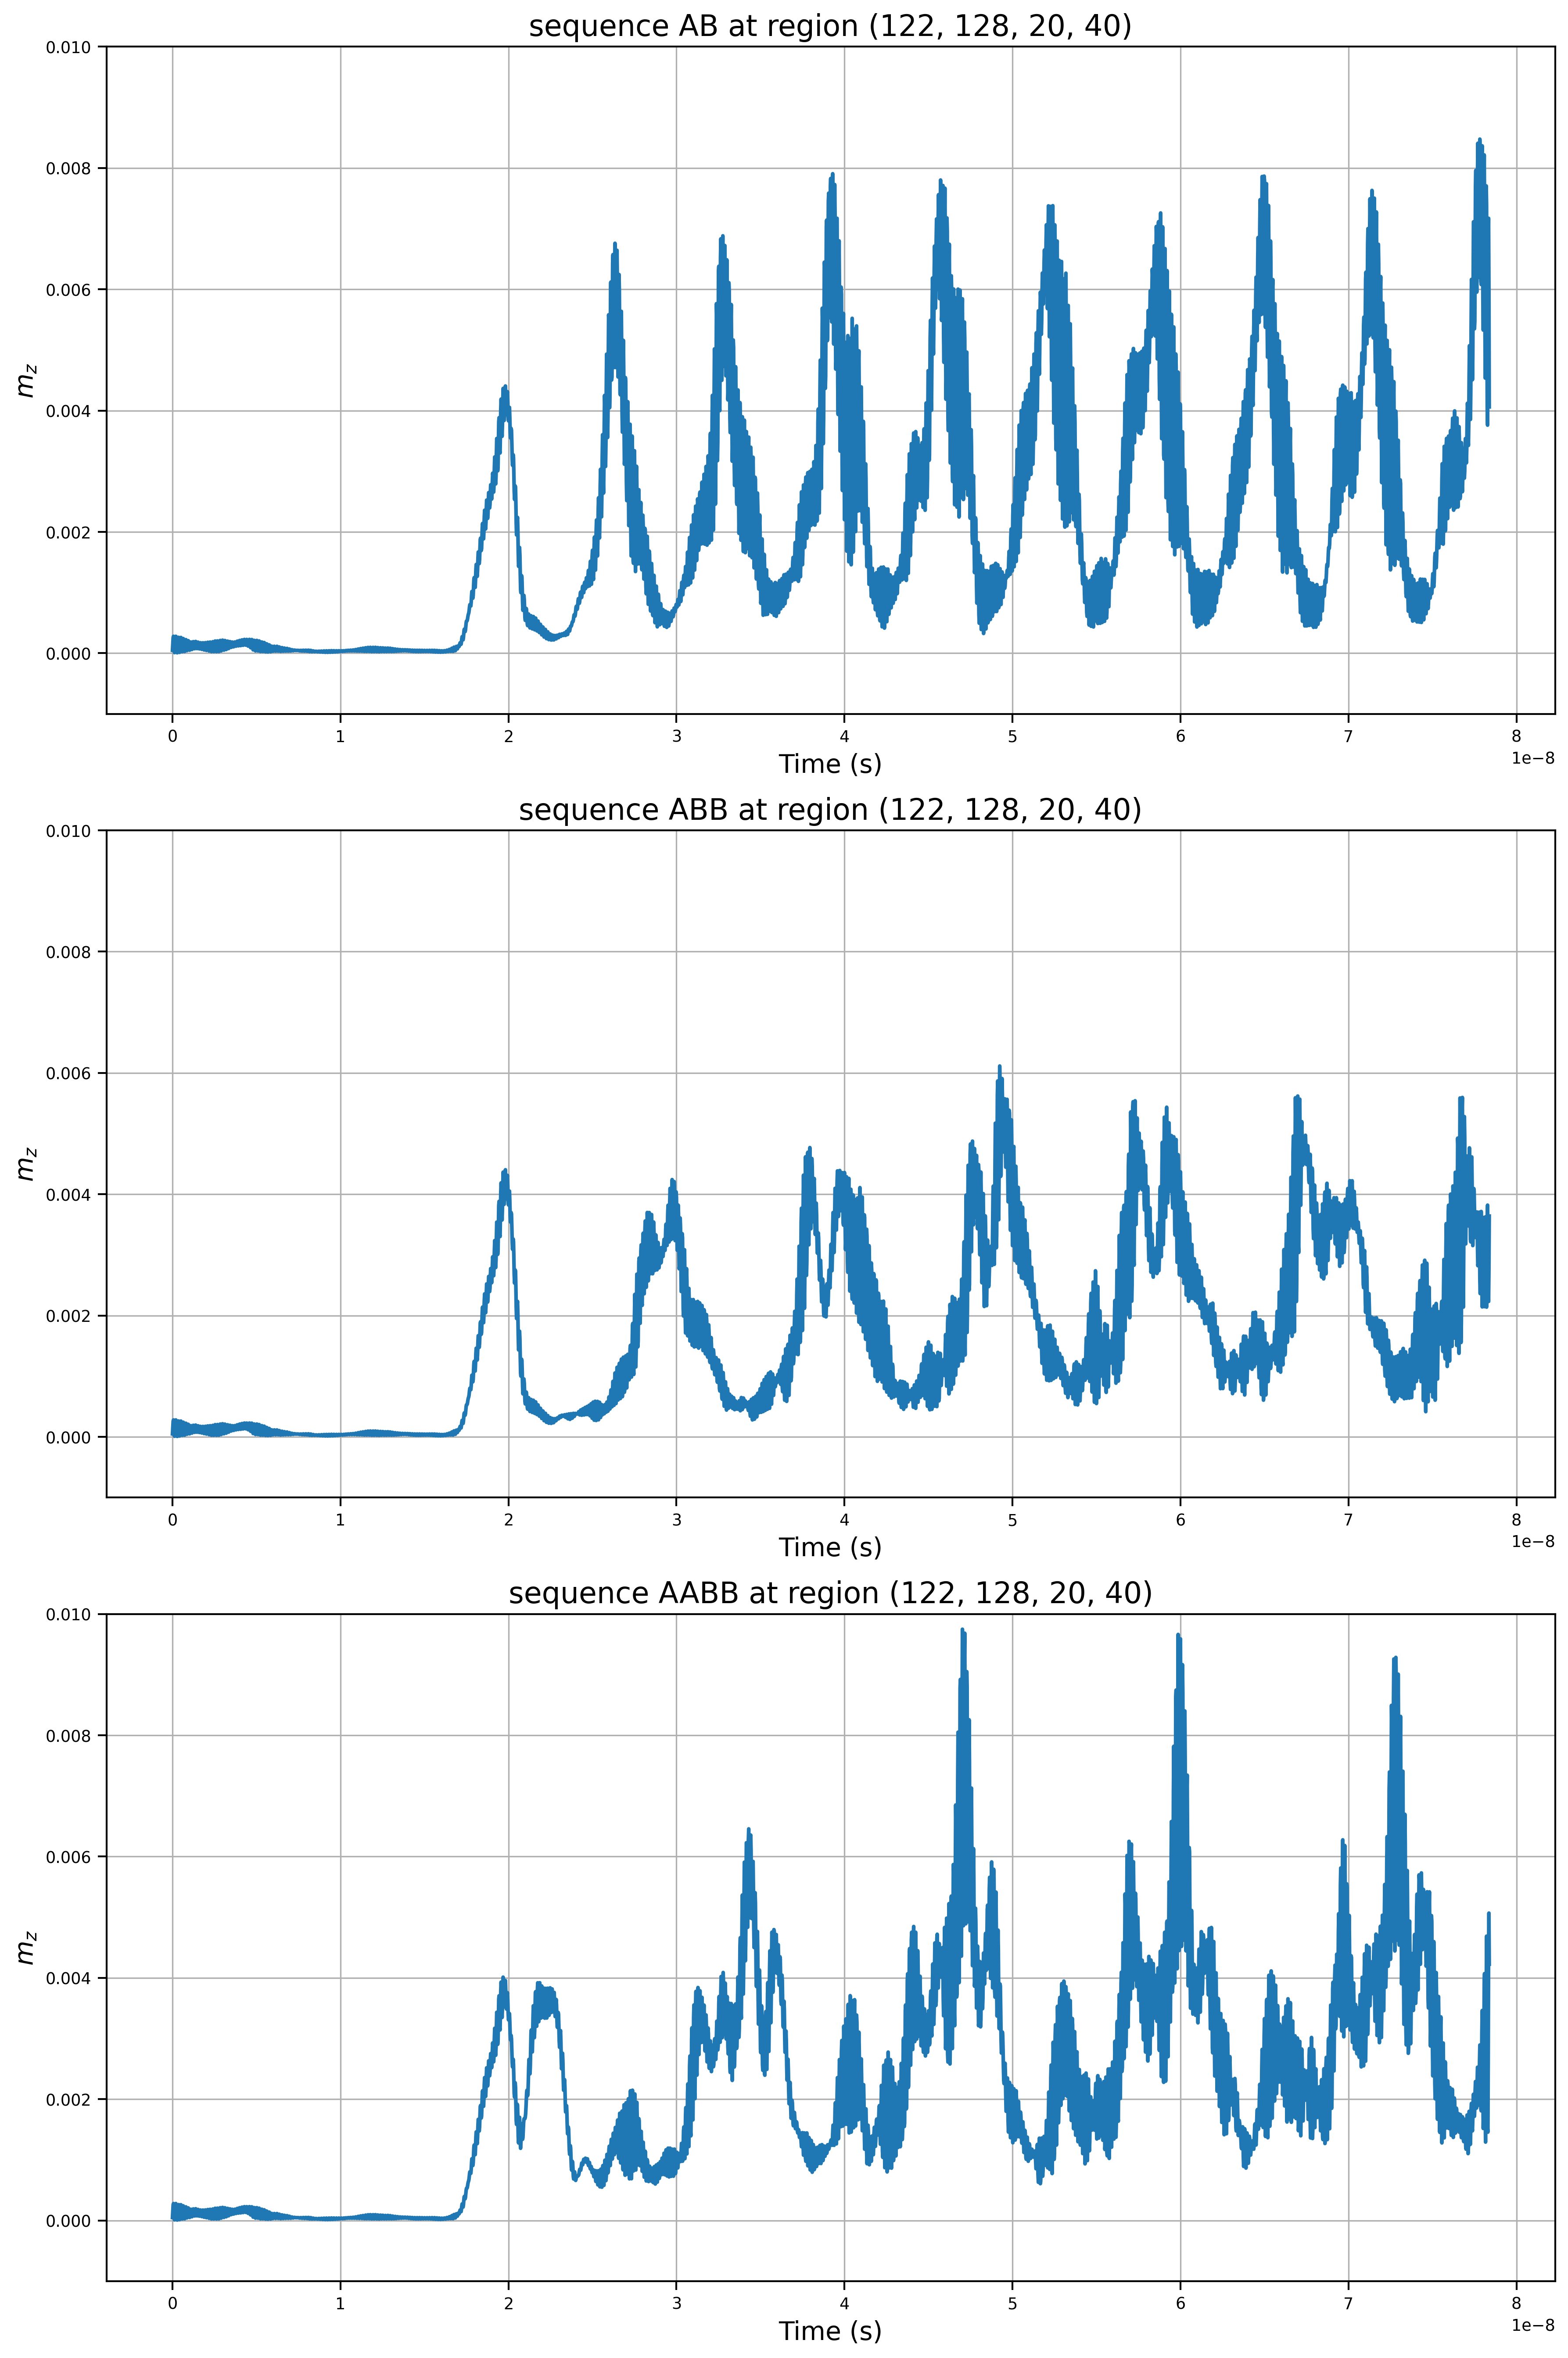

In [68]:
# best region afeter frid search
x_start = 122
x_end = 128
y_start = 20
y_end = 40
title1 = rf'sequence AB at region ({x_start}, {x_end}, {y_start}, {y_end})'
title2 = rf'sequence ABB at region ({x_start}, {x_end}, {y_start}, {y_end})'
title3 = rf'sequence AABB at region ({x_start}, {x_end}, {y_start}, {y_end})'
fig, axs = plt.subplots(3, 1, figsize=(12, 18), dpi=300)
epoch_target = 2
y_max = 0.01


mz2_region_AB = plot_power_in_region_over_time(mz_squared_AB[epoch_target +1], x_start, x_end, y_start, y_end, dt, title1, axs[0],y_max)
mz2_region_ABB = plot_power_in_region_over_time(mz_squared_ABB[epoch_target], x_start, x_end, y_start, y_end, dt, title2, axs[1], y_max)
mz2_region_AABB = plot_power_in_region_over_time(mz_squared_AABB[epoch_target], x_start, x_end, y_start, y_end, dt, title3, axs[2], y_max)

# 调整布局以适应所有子图
plt.tight_layout()
plt.show()

In [77]:
mz2_region_AB

tensor([4.8062e-05, 1.5943e-04, 2.5846e-04,  ..., 7.1704e-03, 5.9884e-03,
        4.0606e-03])

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def smooth_signal(signal, window_size=5, method='moving_average'):
    """
    对信号进行平滑处理。
    
    参数:
    signal (np.array): 输入信号。
    window_size (int): 平滑窗口大小。
    method (str): 平滑方法 ('moving_average' 或 'gaussian')。
    
    返回:
    np.array: 平滑后的信号。
    """
    if method == 'moving_average':
        kernel = np.ones(window_size) / window_size
        smoothed_signal = np.convolve(signal, kernel, mode='same')
    elif method == 'gaussian':
        kernel = np.exp(-np.linspace(-(window_size // 2), window_size // 2, window_size)**2 / 2)
        kernel /= kernel.sum()
        smoothed_signal = np.convolve(signal, kernel, mode='same')
    else:
        raise ValueError("Unsupported smoothing method. Use 'moving_average' or 'gaussian'.")
    
    return smoothed_signal

def compute_autocorrelation(signal):
    """
    计算信号的自相关函数。
    
    参数:
    signal (np.array): 输入信号。
    
    返回:
    np.array: 自相关函数。
    """
    signal = signal - np.mean(signal)
    autocorr = np.correlate(signal, signal, mode='full')
    autocorr = autocorr[autocorr.size // 2:]
    return autocorr

def extract_period_from_autocorrelation(autocorr, sampling_rate):
    """
    从自相关函数中提取主要周期。
    
    参数:
    autocorr (np.array): 自相关函数。
    sampling_rate (float): 采样率。
    
    返回:
    float: 信号的主要周期。
    """
    peaks, _ = find_peaks(autocorr)
    if len(peaks) > 1:
        main_period_index = peaks[2]  # 选择第一个峰值位置作为周期
        main_period = main_period_index / sampling_rate
    else:
        main_period = None
    return main_period

def compute_fft(signal, sampling_rate):
    """
    计算信号的傅里叶变换并提取频谱。
    
    参数:
    signal (np.array): 输入信号。
    sampling_rate (float): 采样率。
    
    返回:
    tuple: 频率和对应的幅度。
    """
    fft_result = np.fft.fft(signal)
    fft_freq = np.fft.fftfreq(len(signal), d=1/sampling_rate)
    magnitude = np.abs(fft_result)
    return fft_freq, magnitude


In [84]:
mz2_region_AB = mz2_region_AB[1200:]
mz2_region_ABB = mz2_region_ABB[1200:]
mz2_region_AABB = mz2_region_AABB[1200:]
signals_matrix = torch.stack([mz2_region_AB, mz2_region_ABB, mz2_region_AABB])
signals_matrix.shape

torch.Size([3, 1770])

Signal 1:
  Main Period from Autocorrelation: 7.344632768361582e-12 seconds


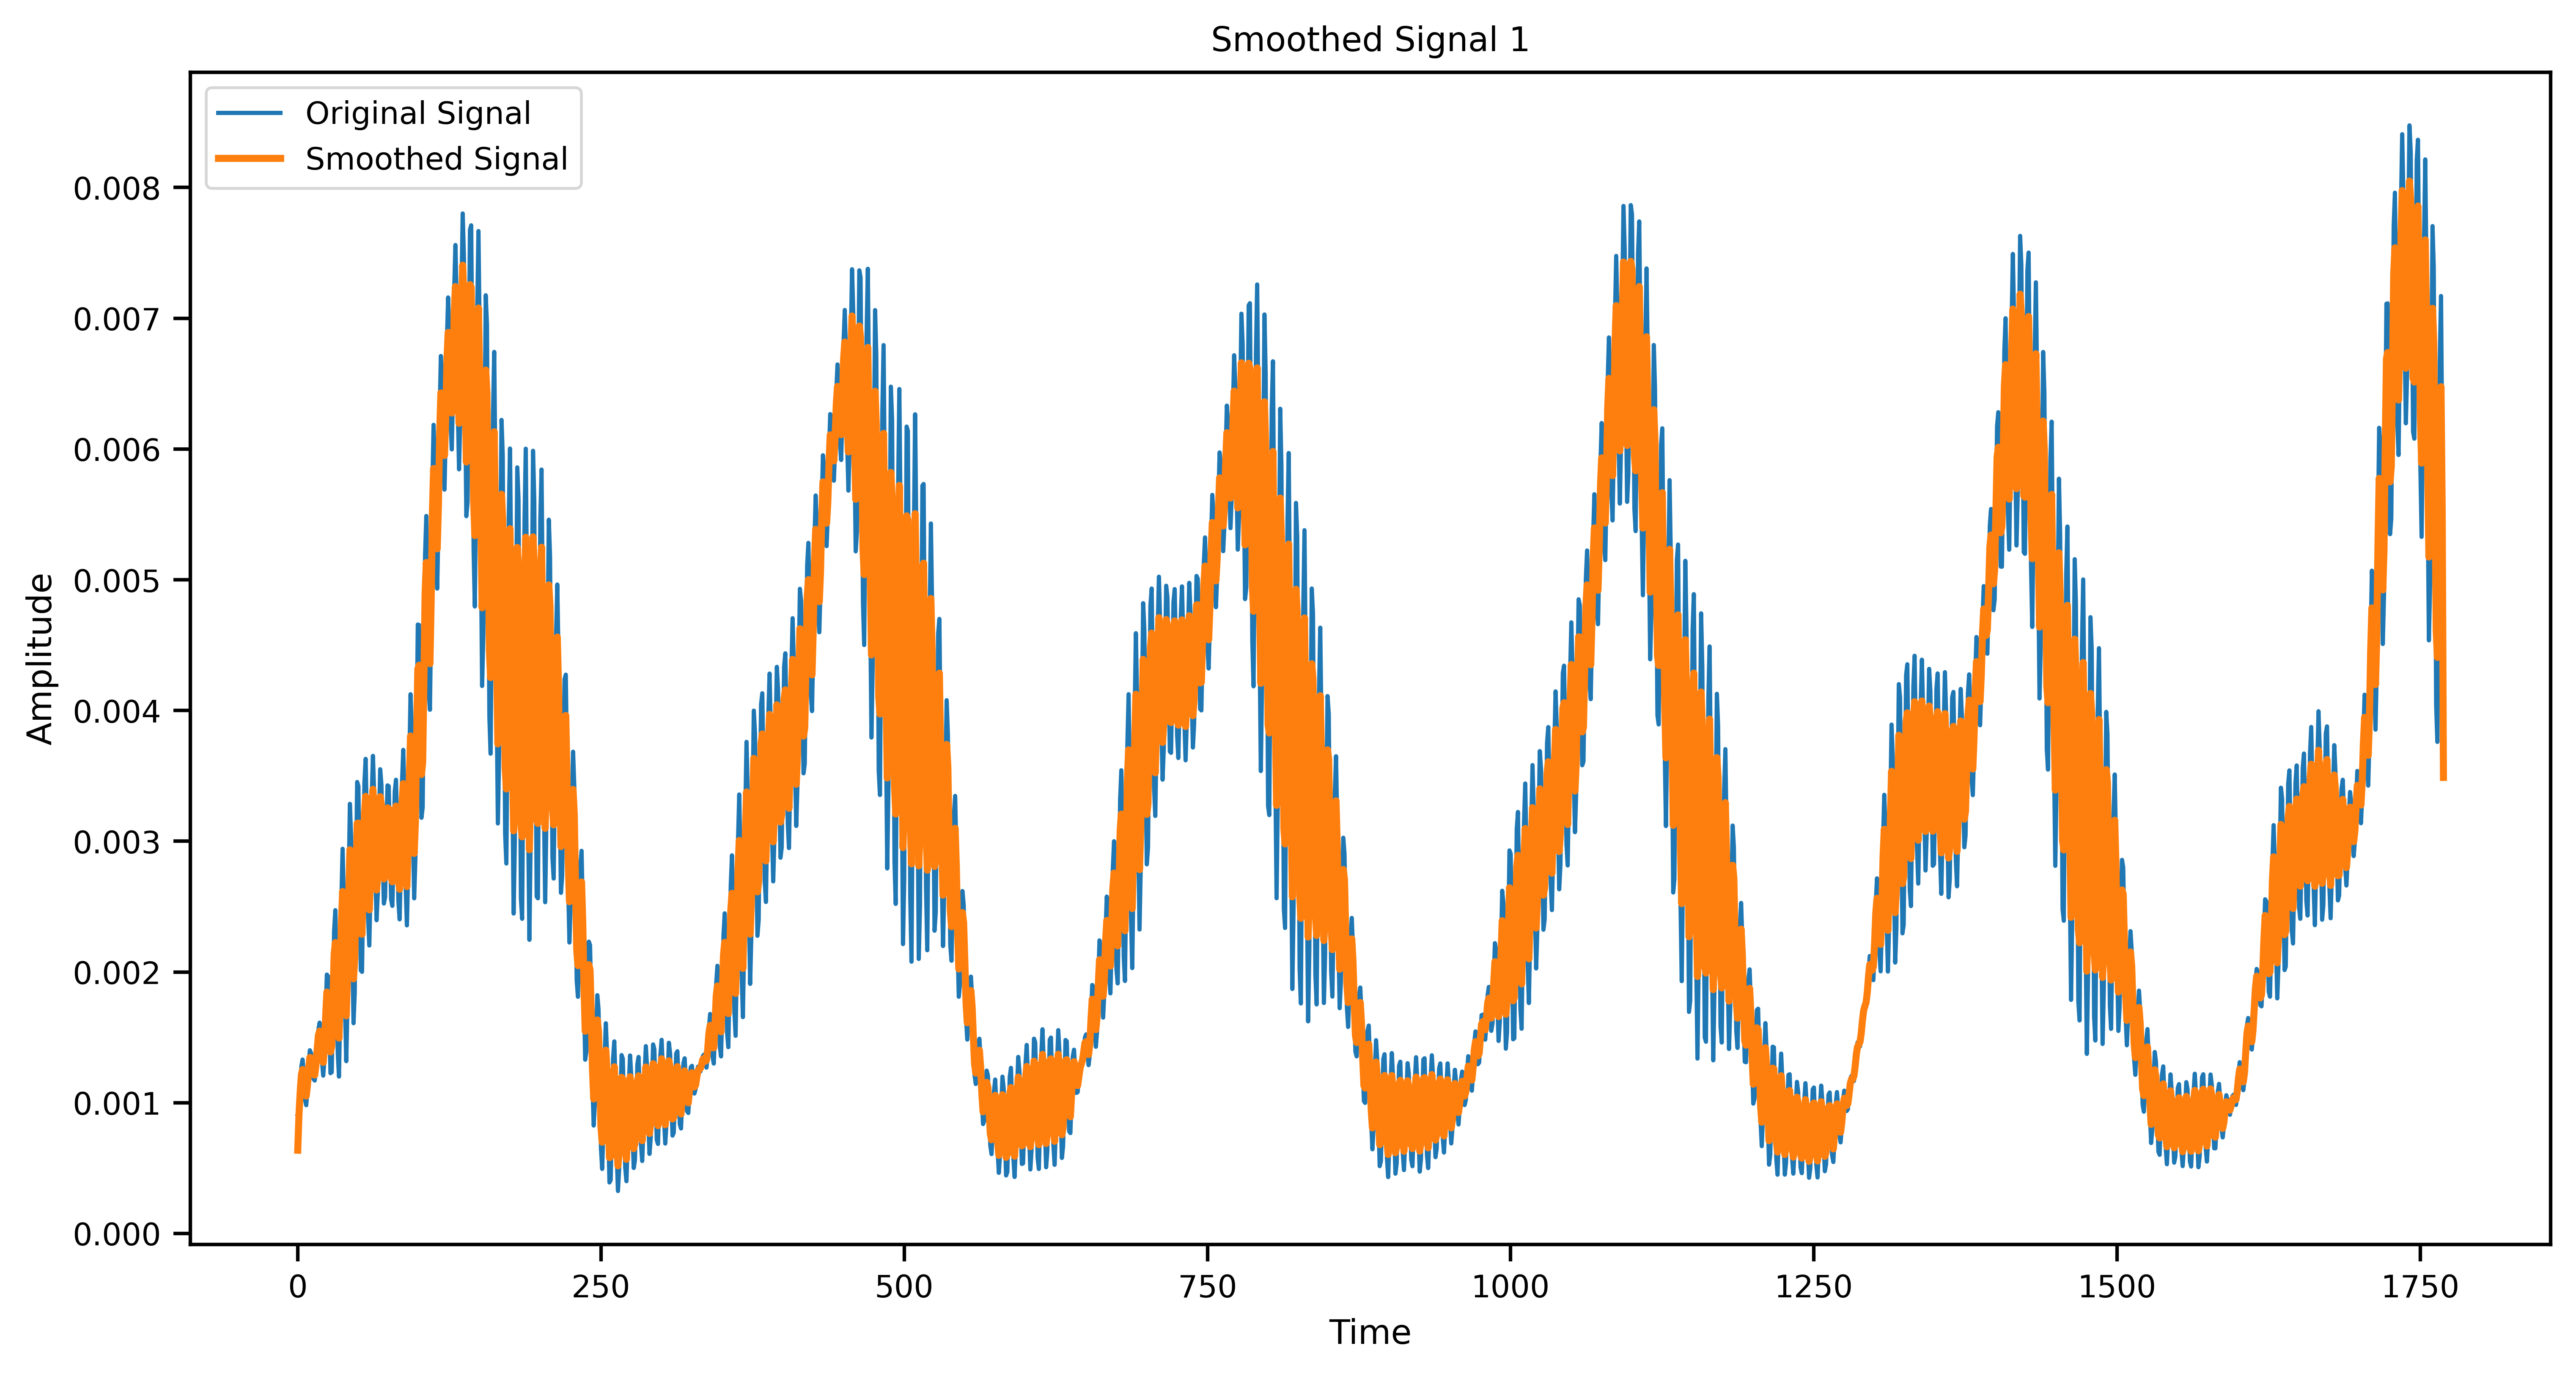

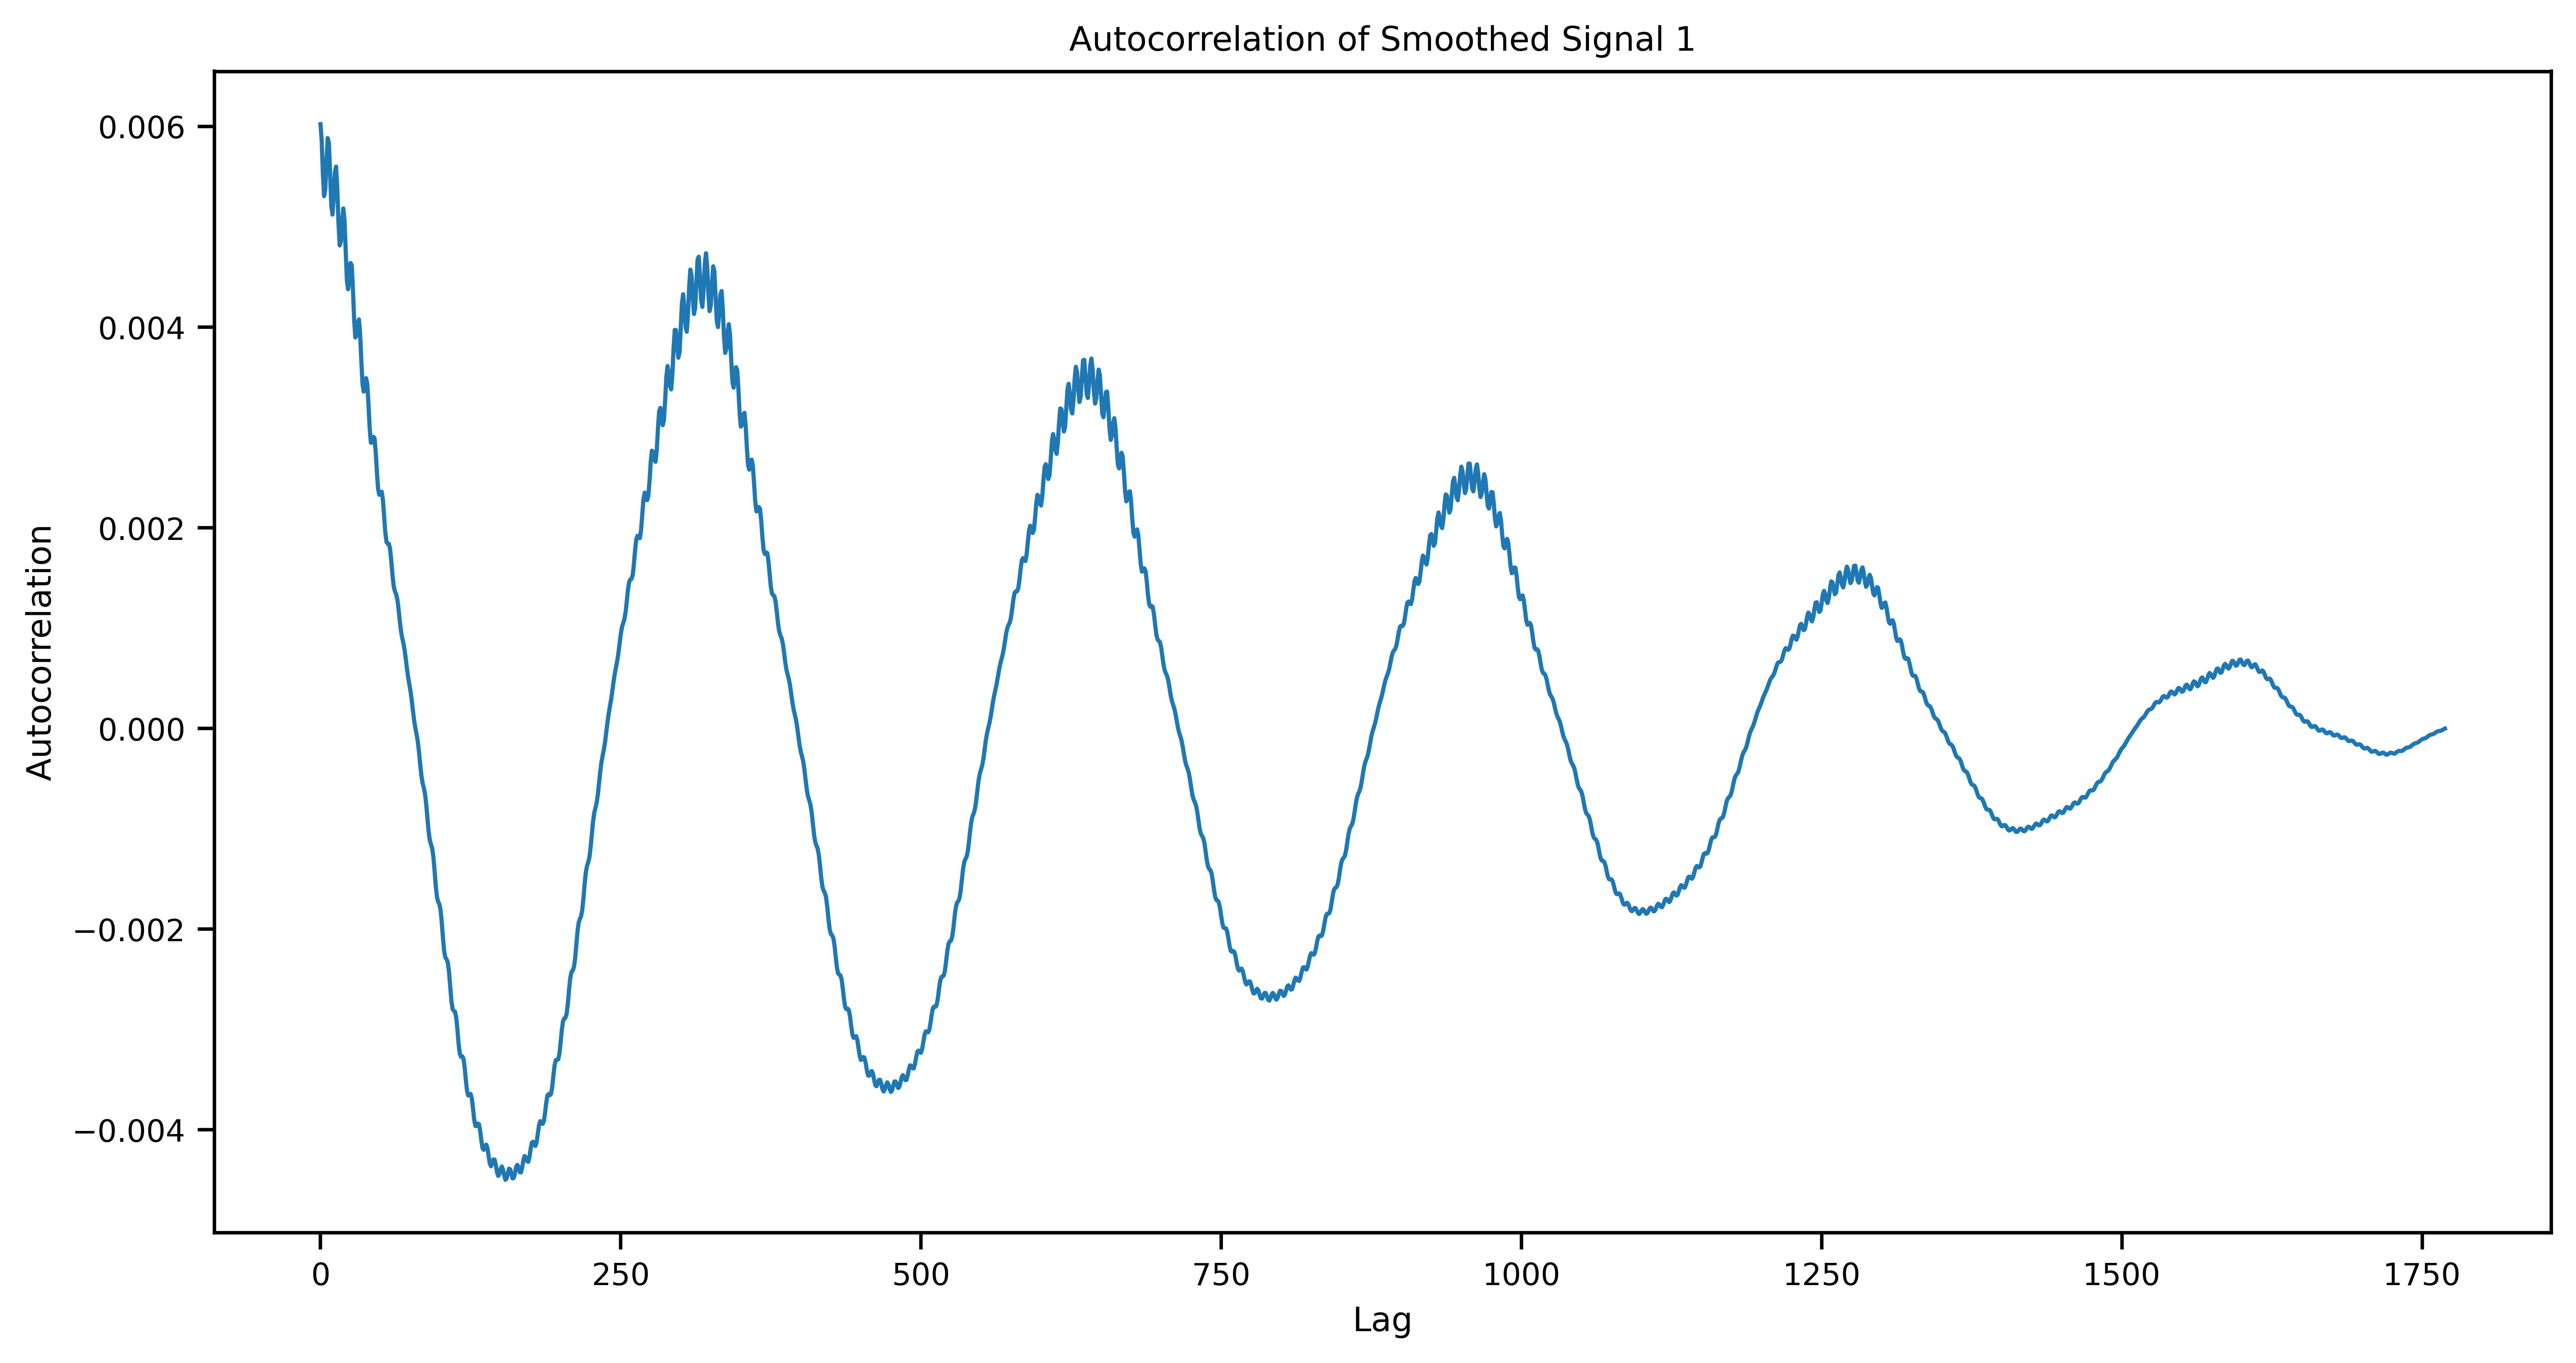

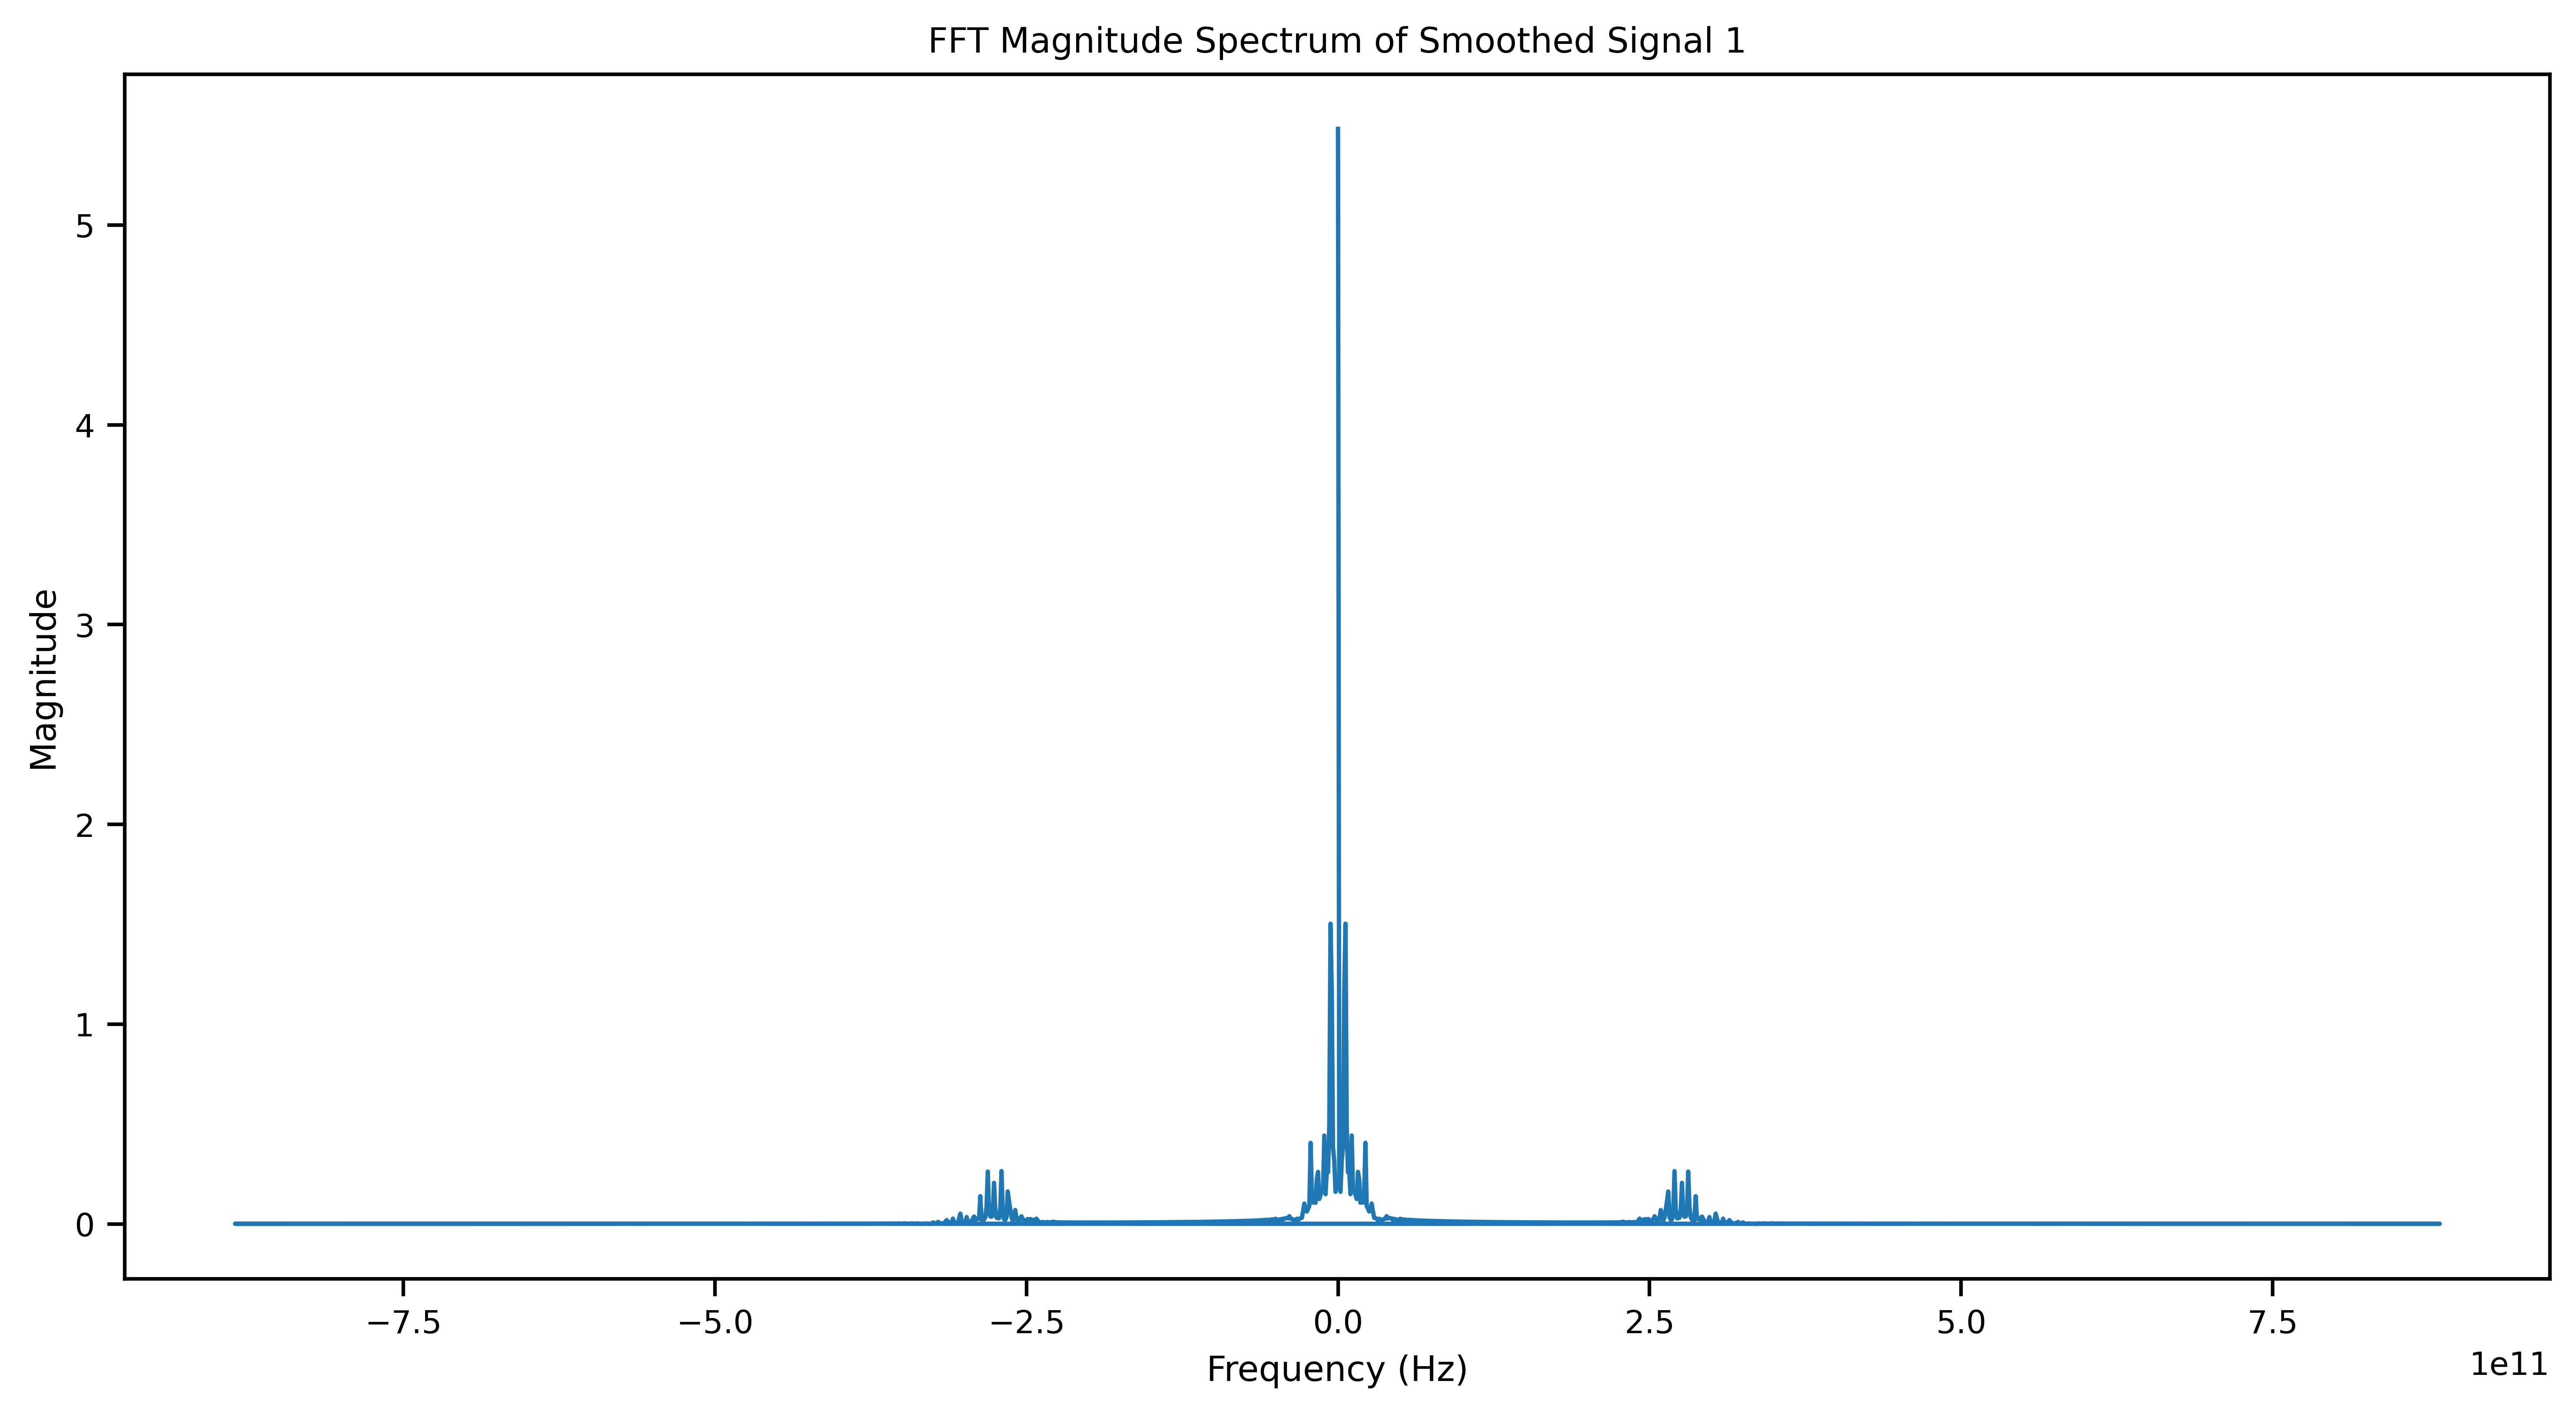

Signal 2:
  Main Period from Autocorrelation: 7.344632768361582e-12 seconds


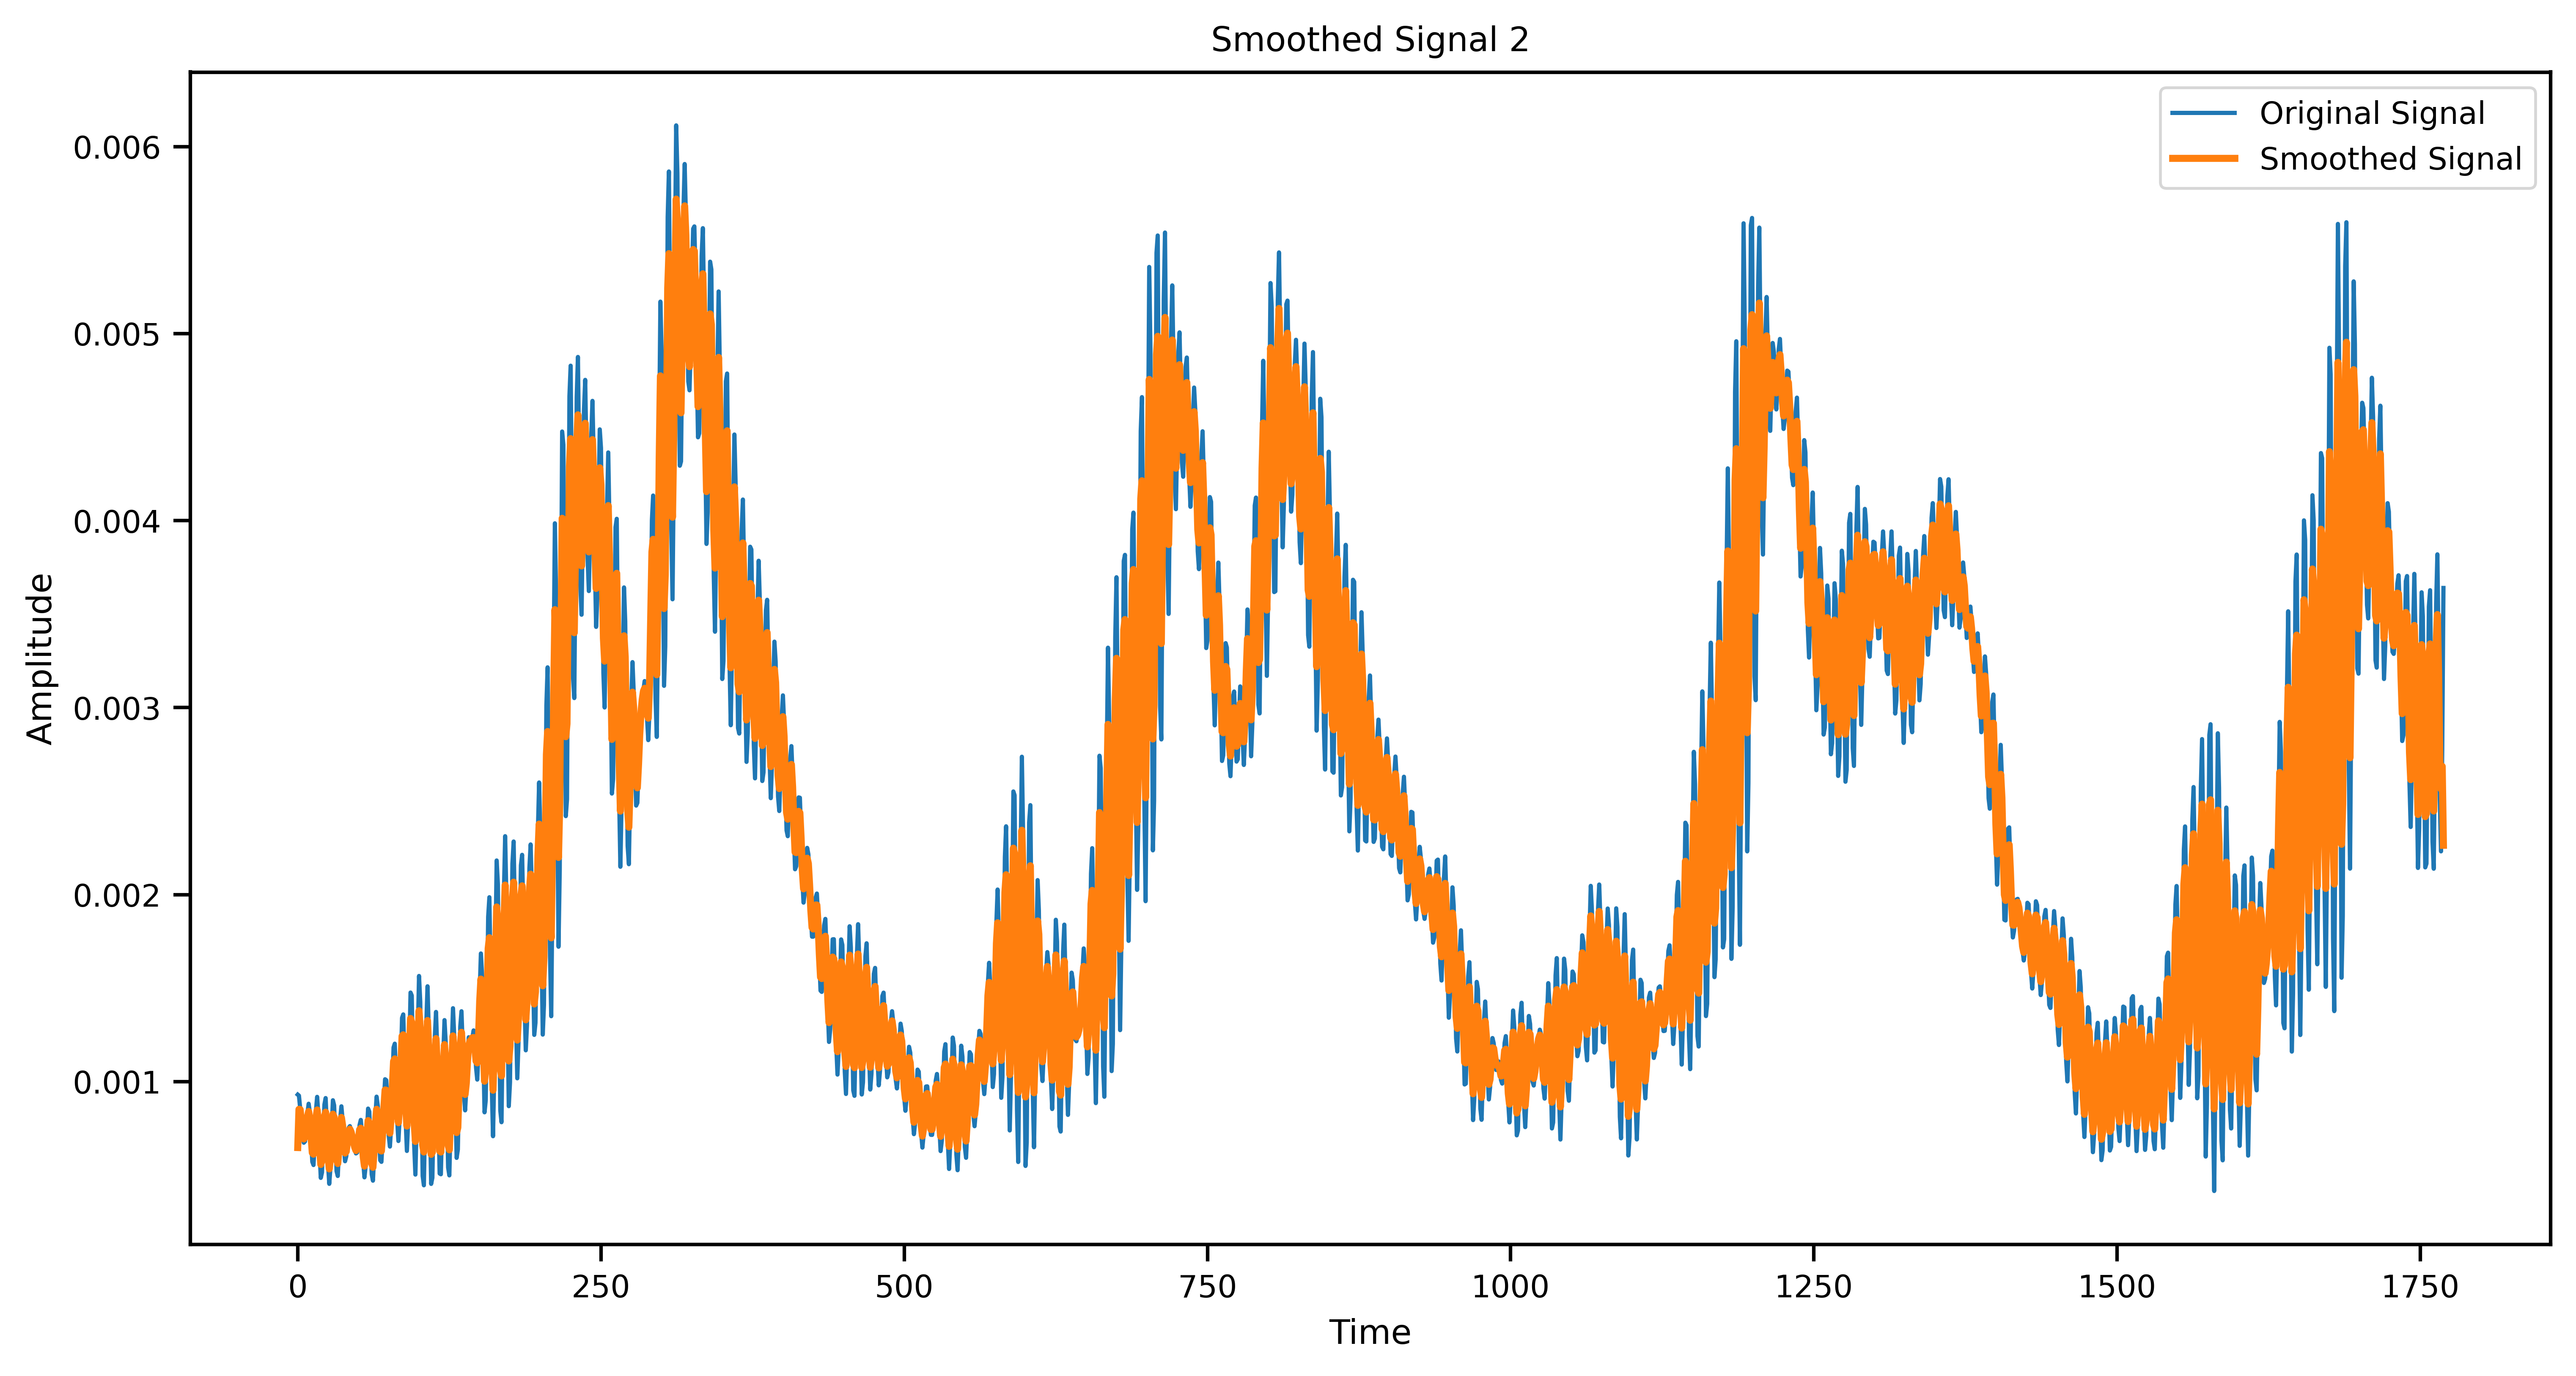

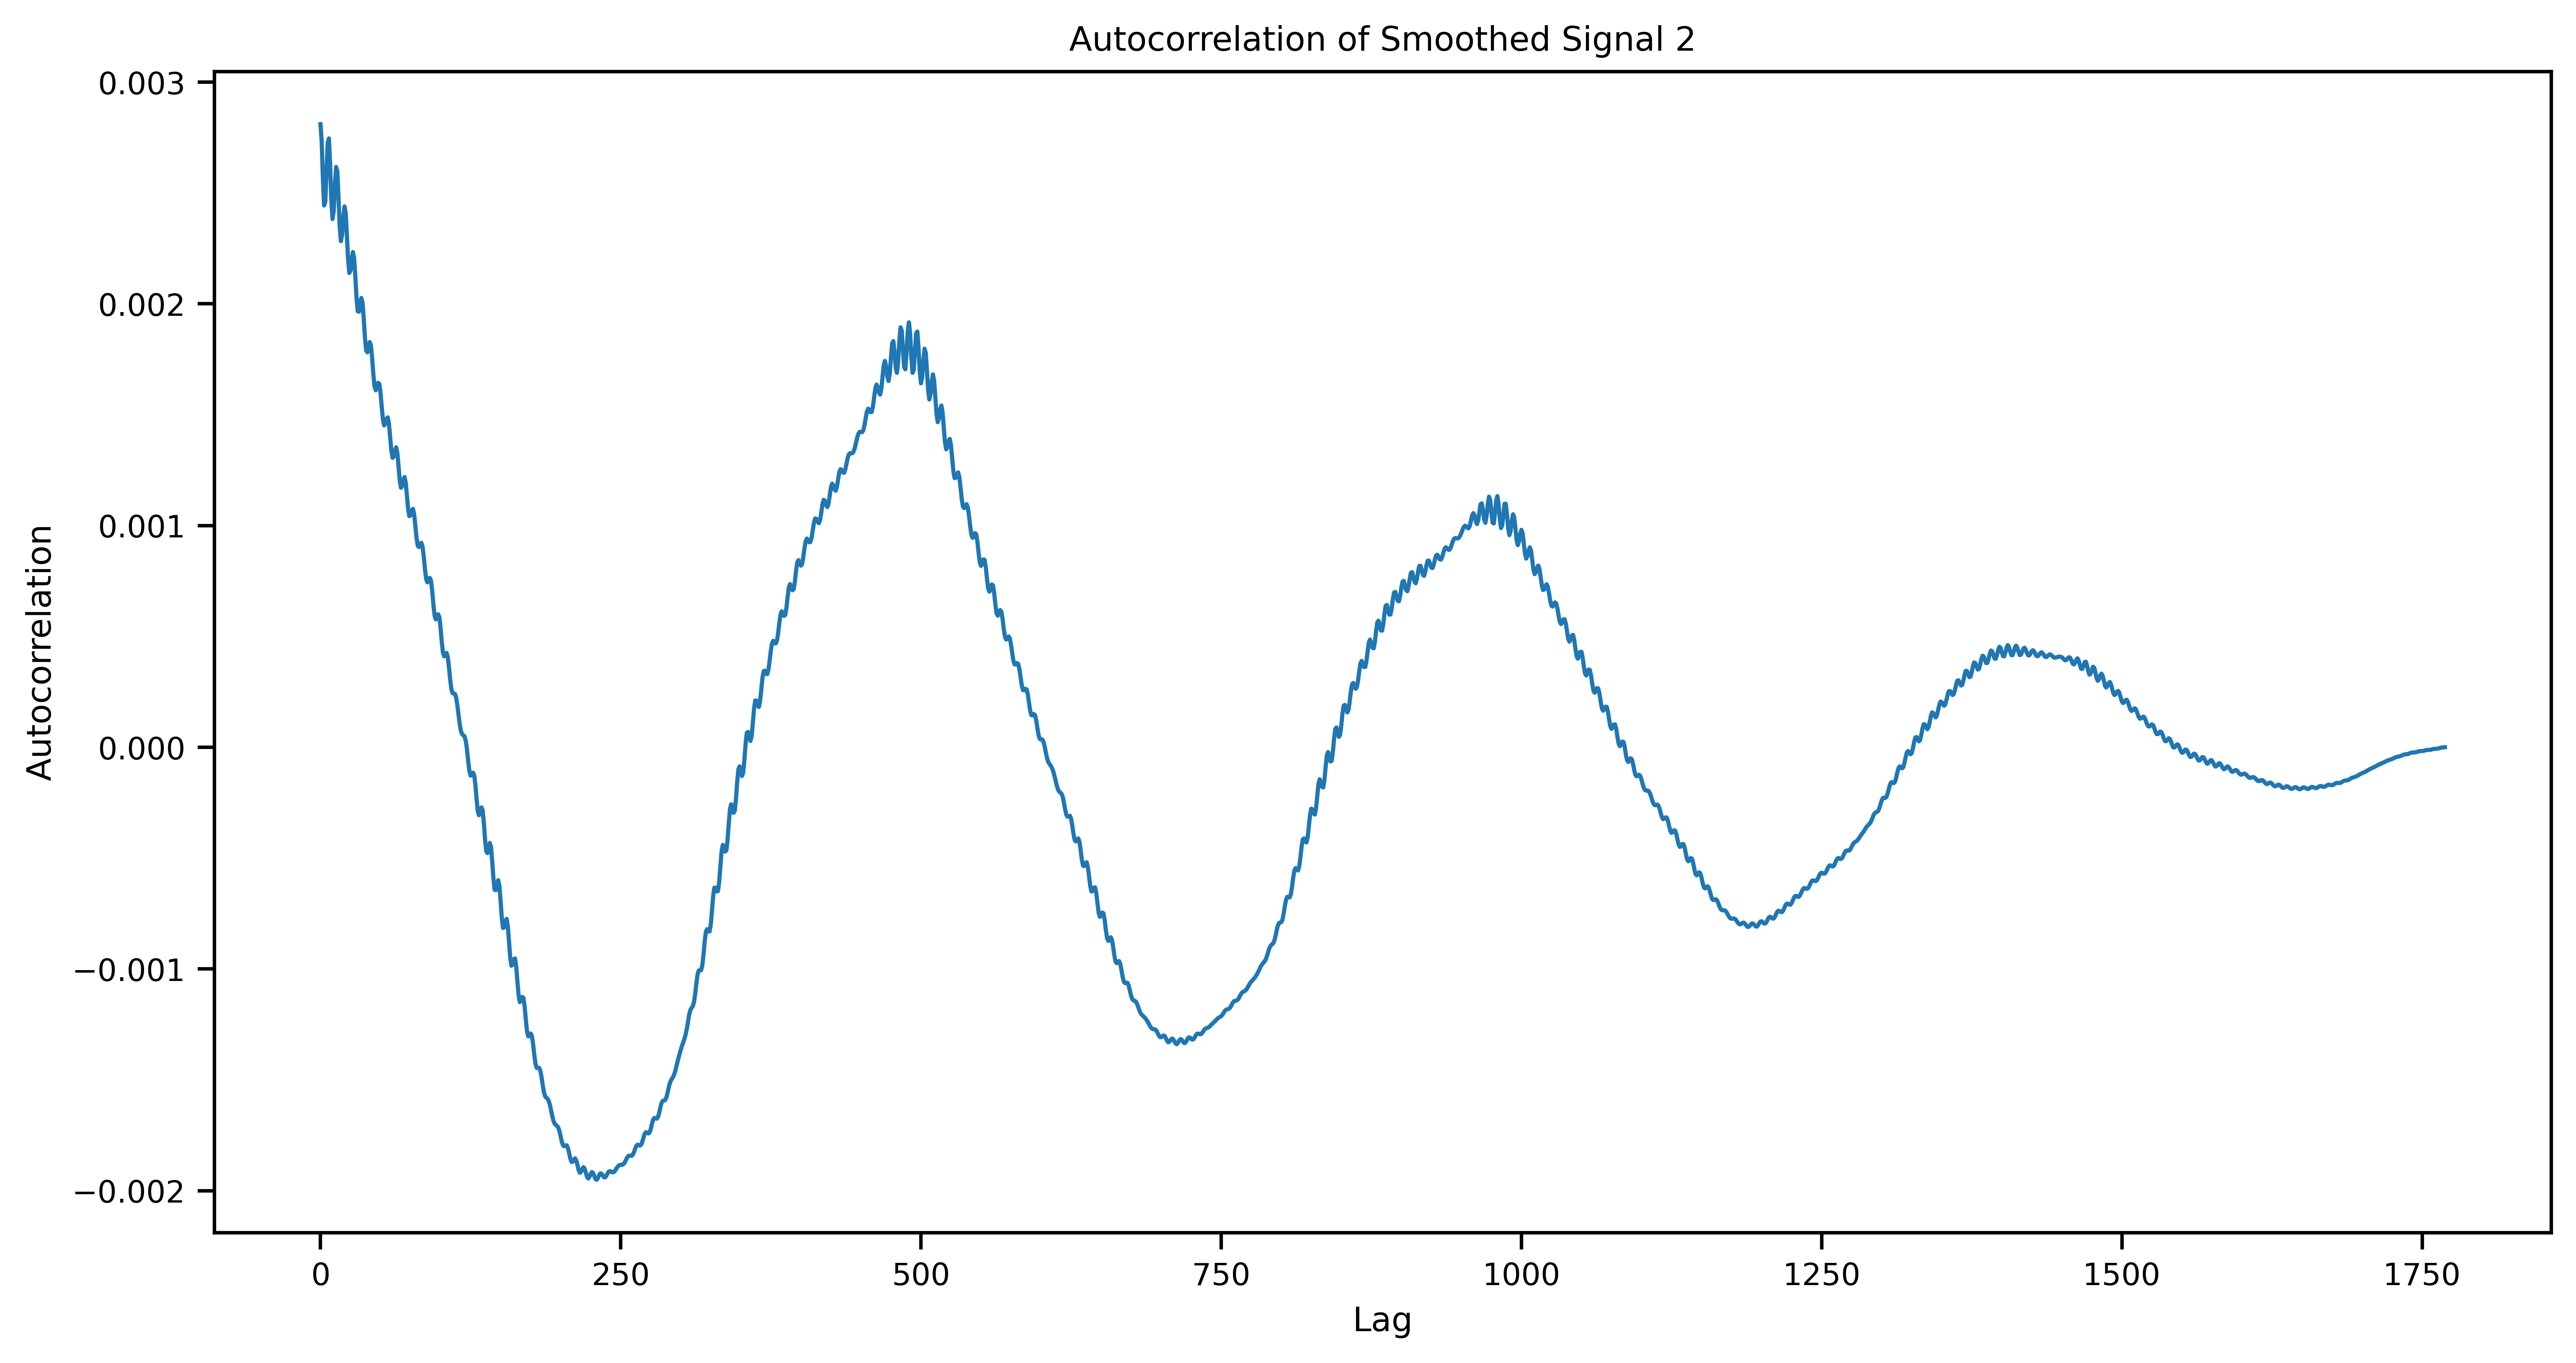

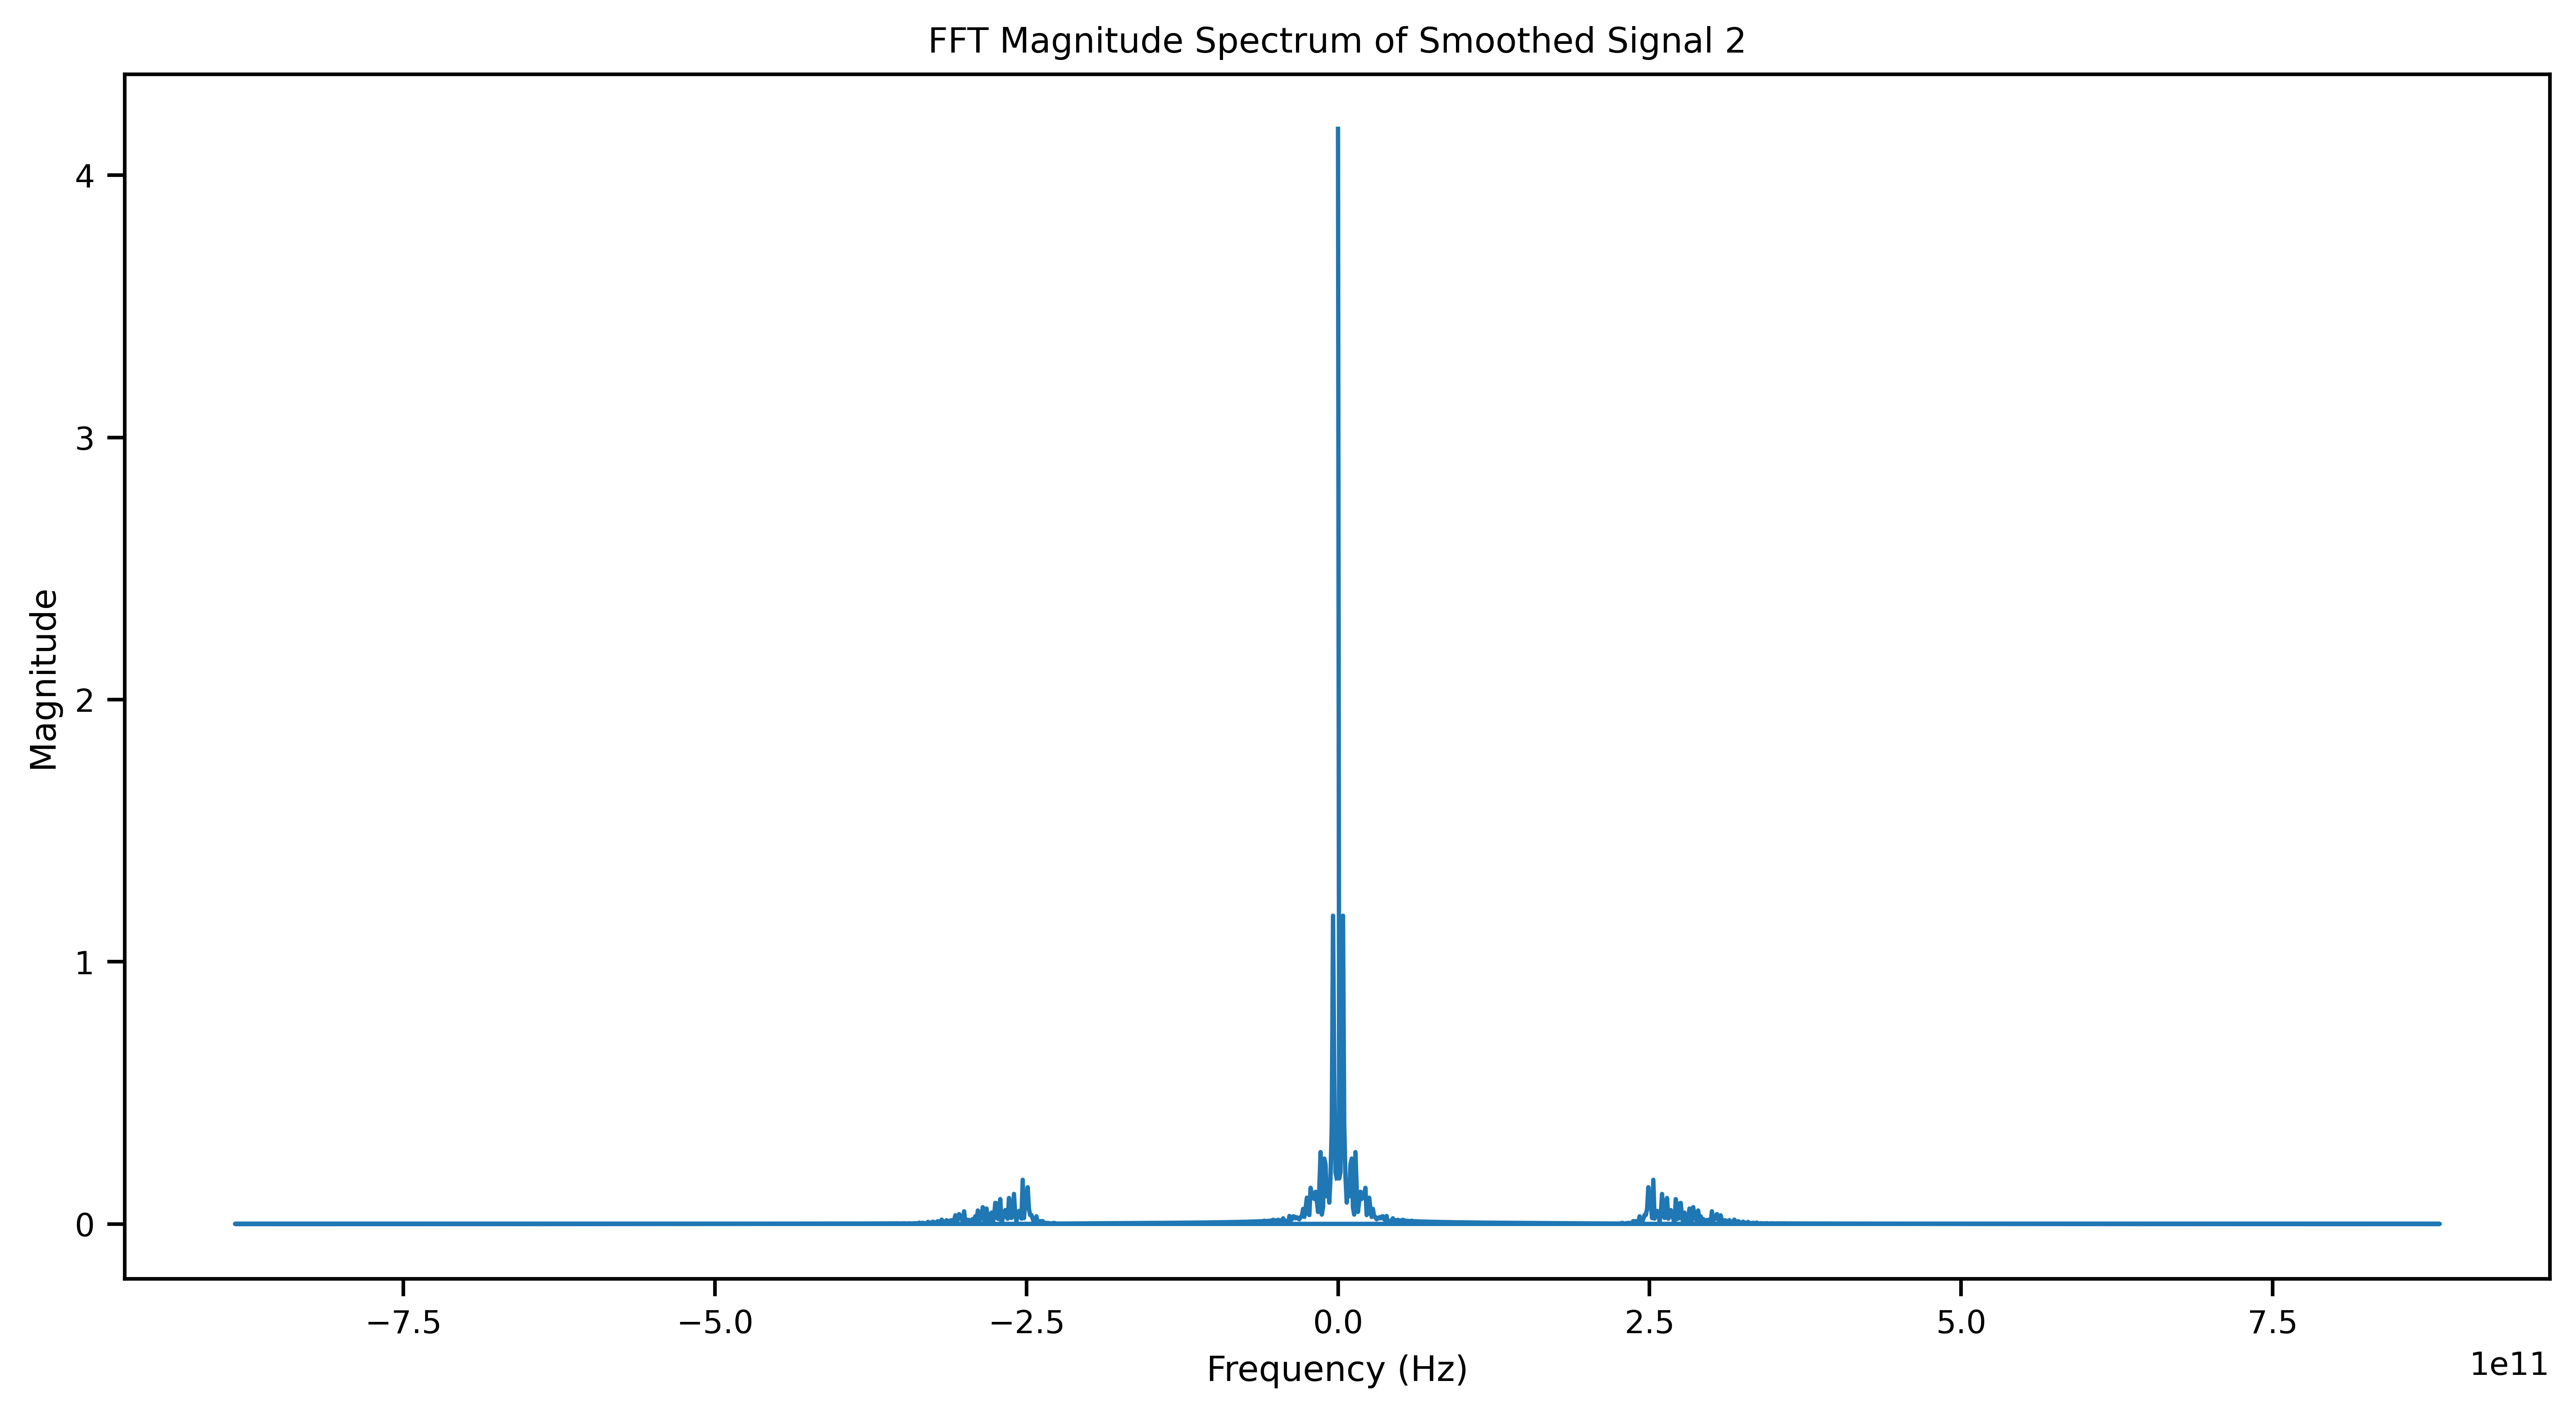

Signal 3:
  Main Period from Autocorrelation: 7.344632768361582e-12 seconds


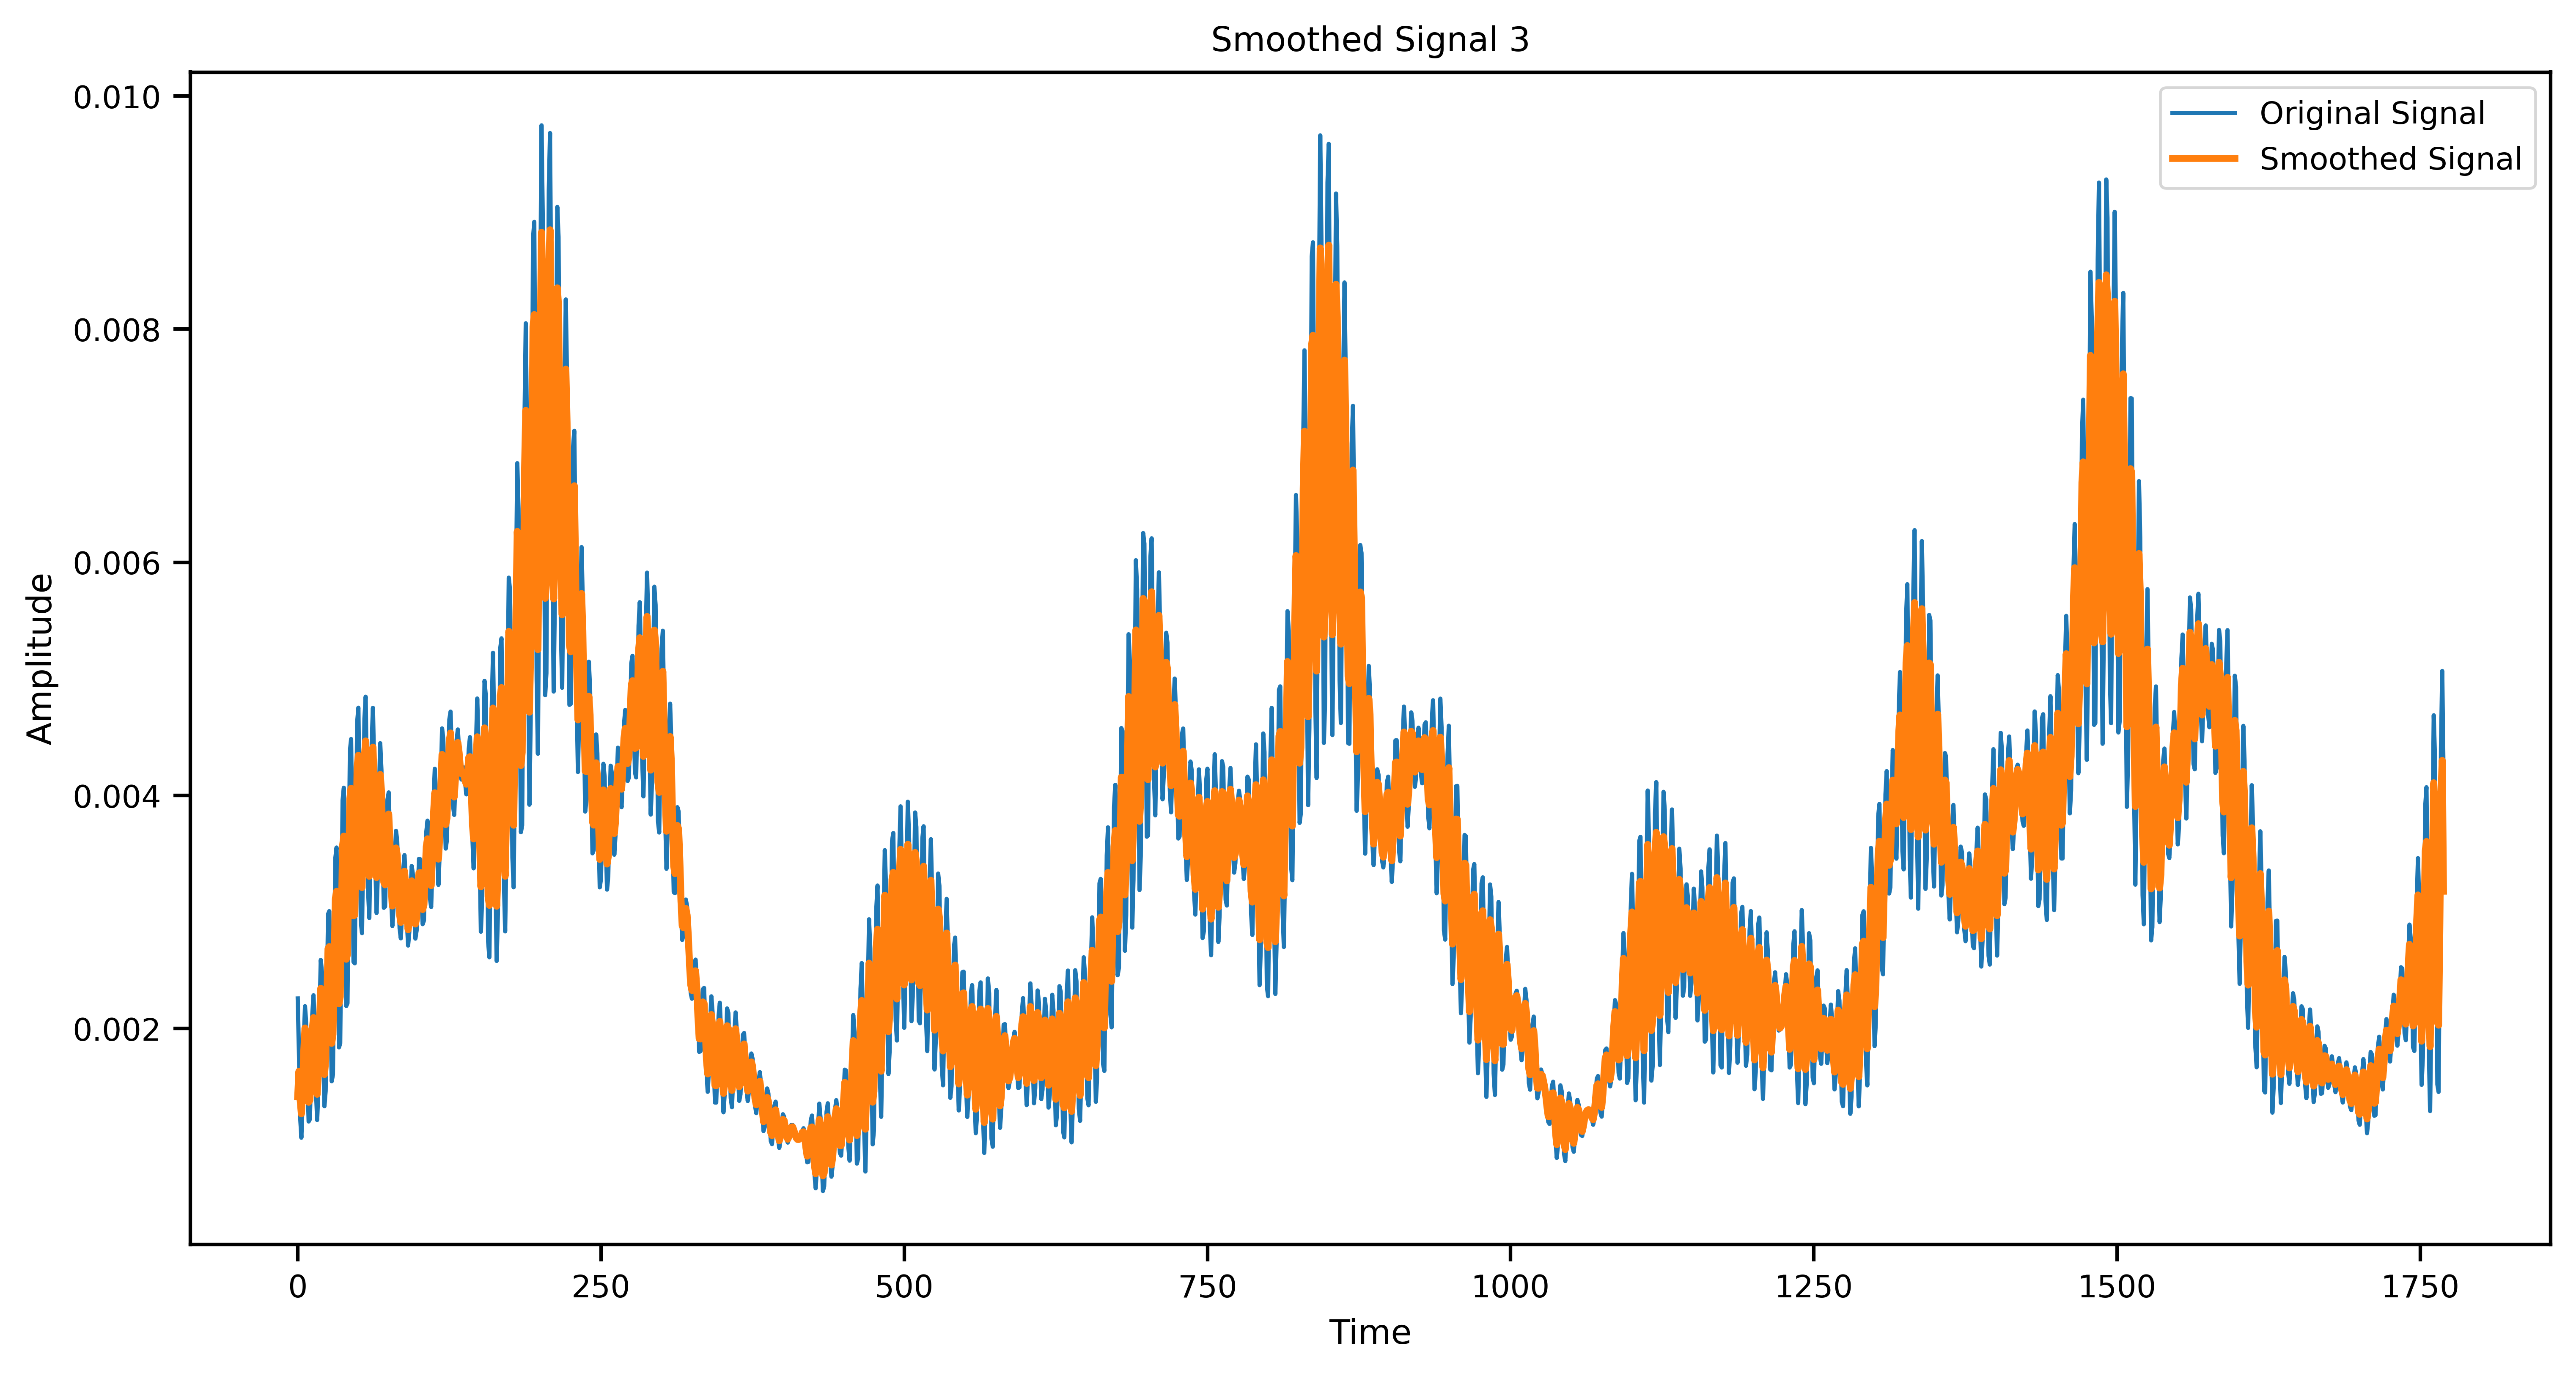

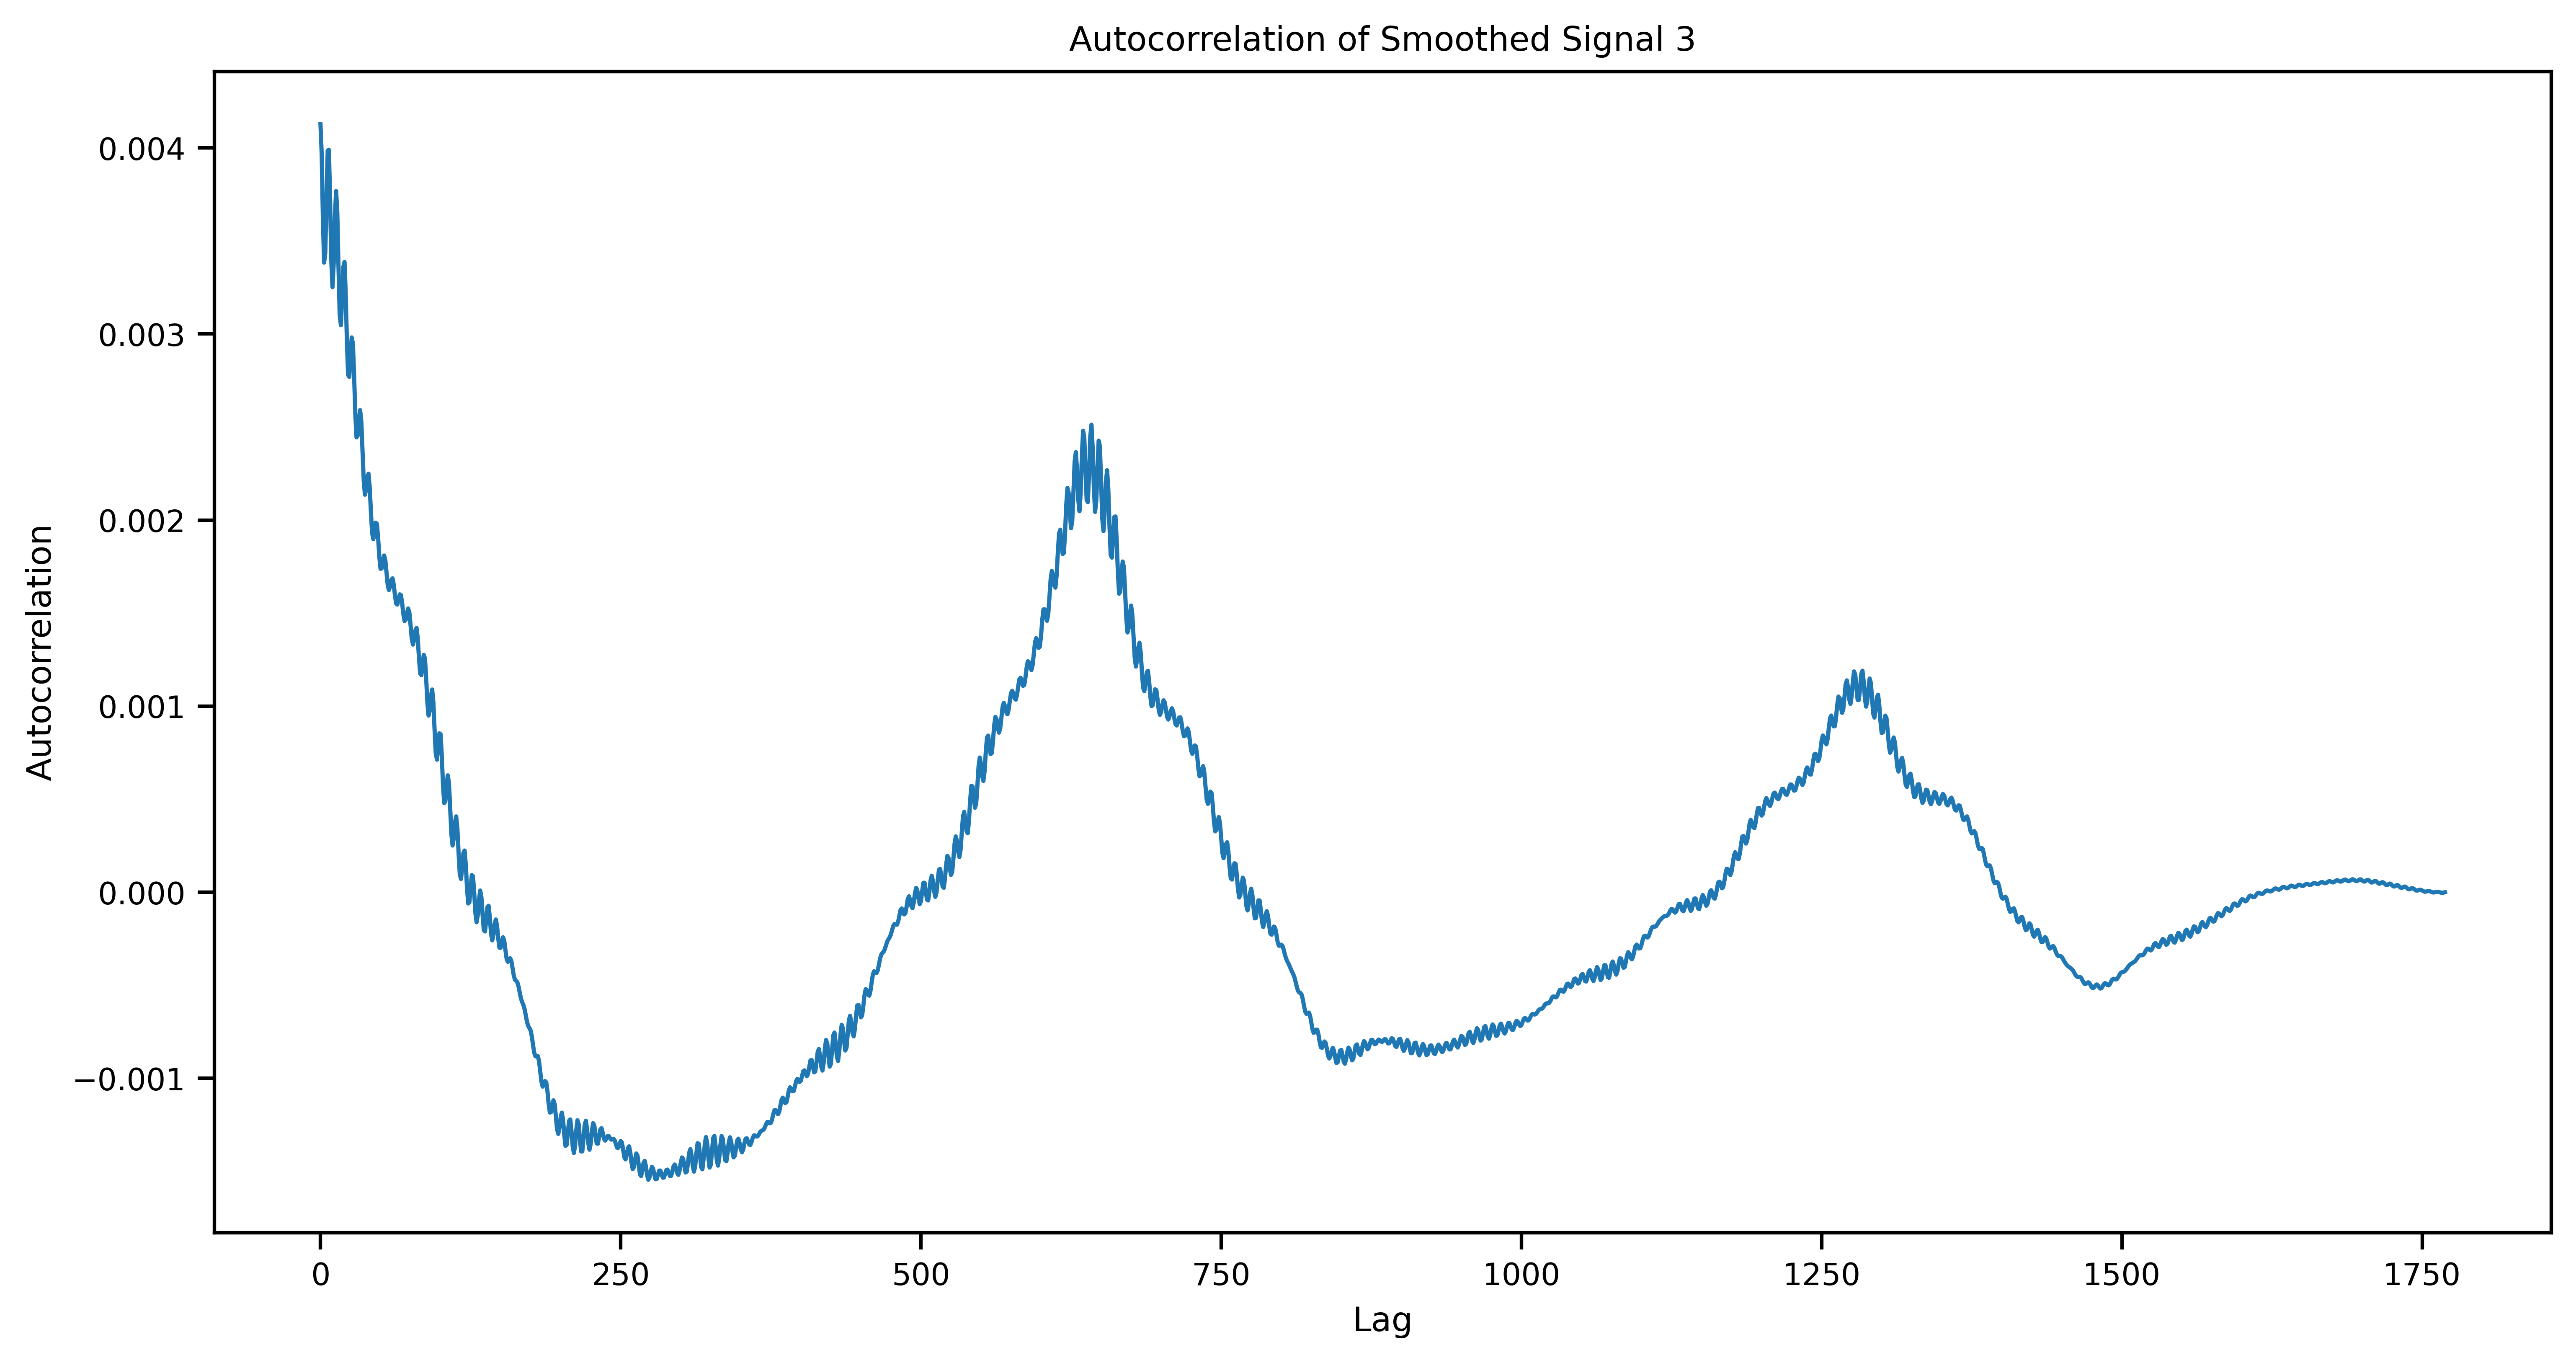

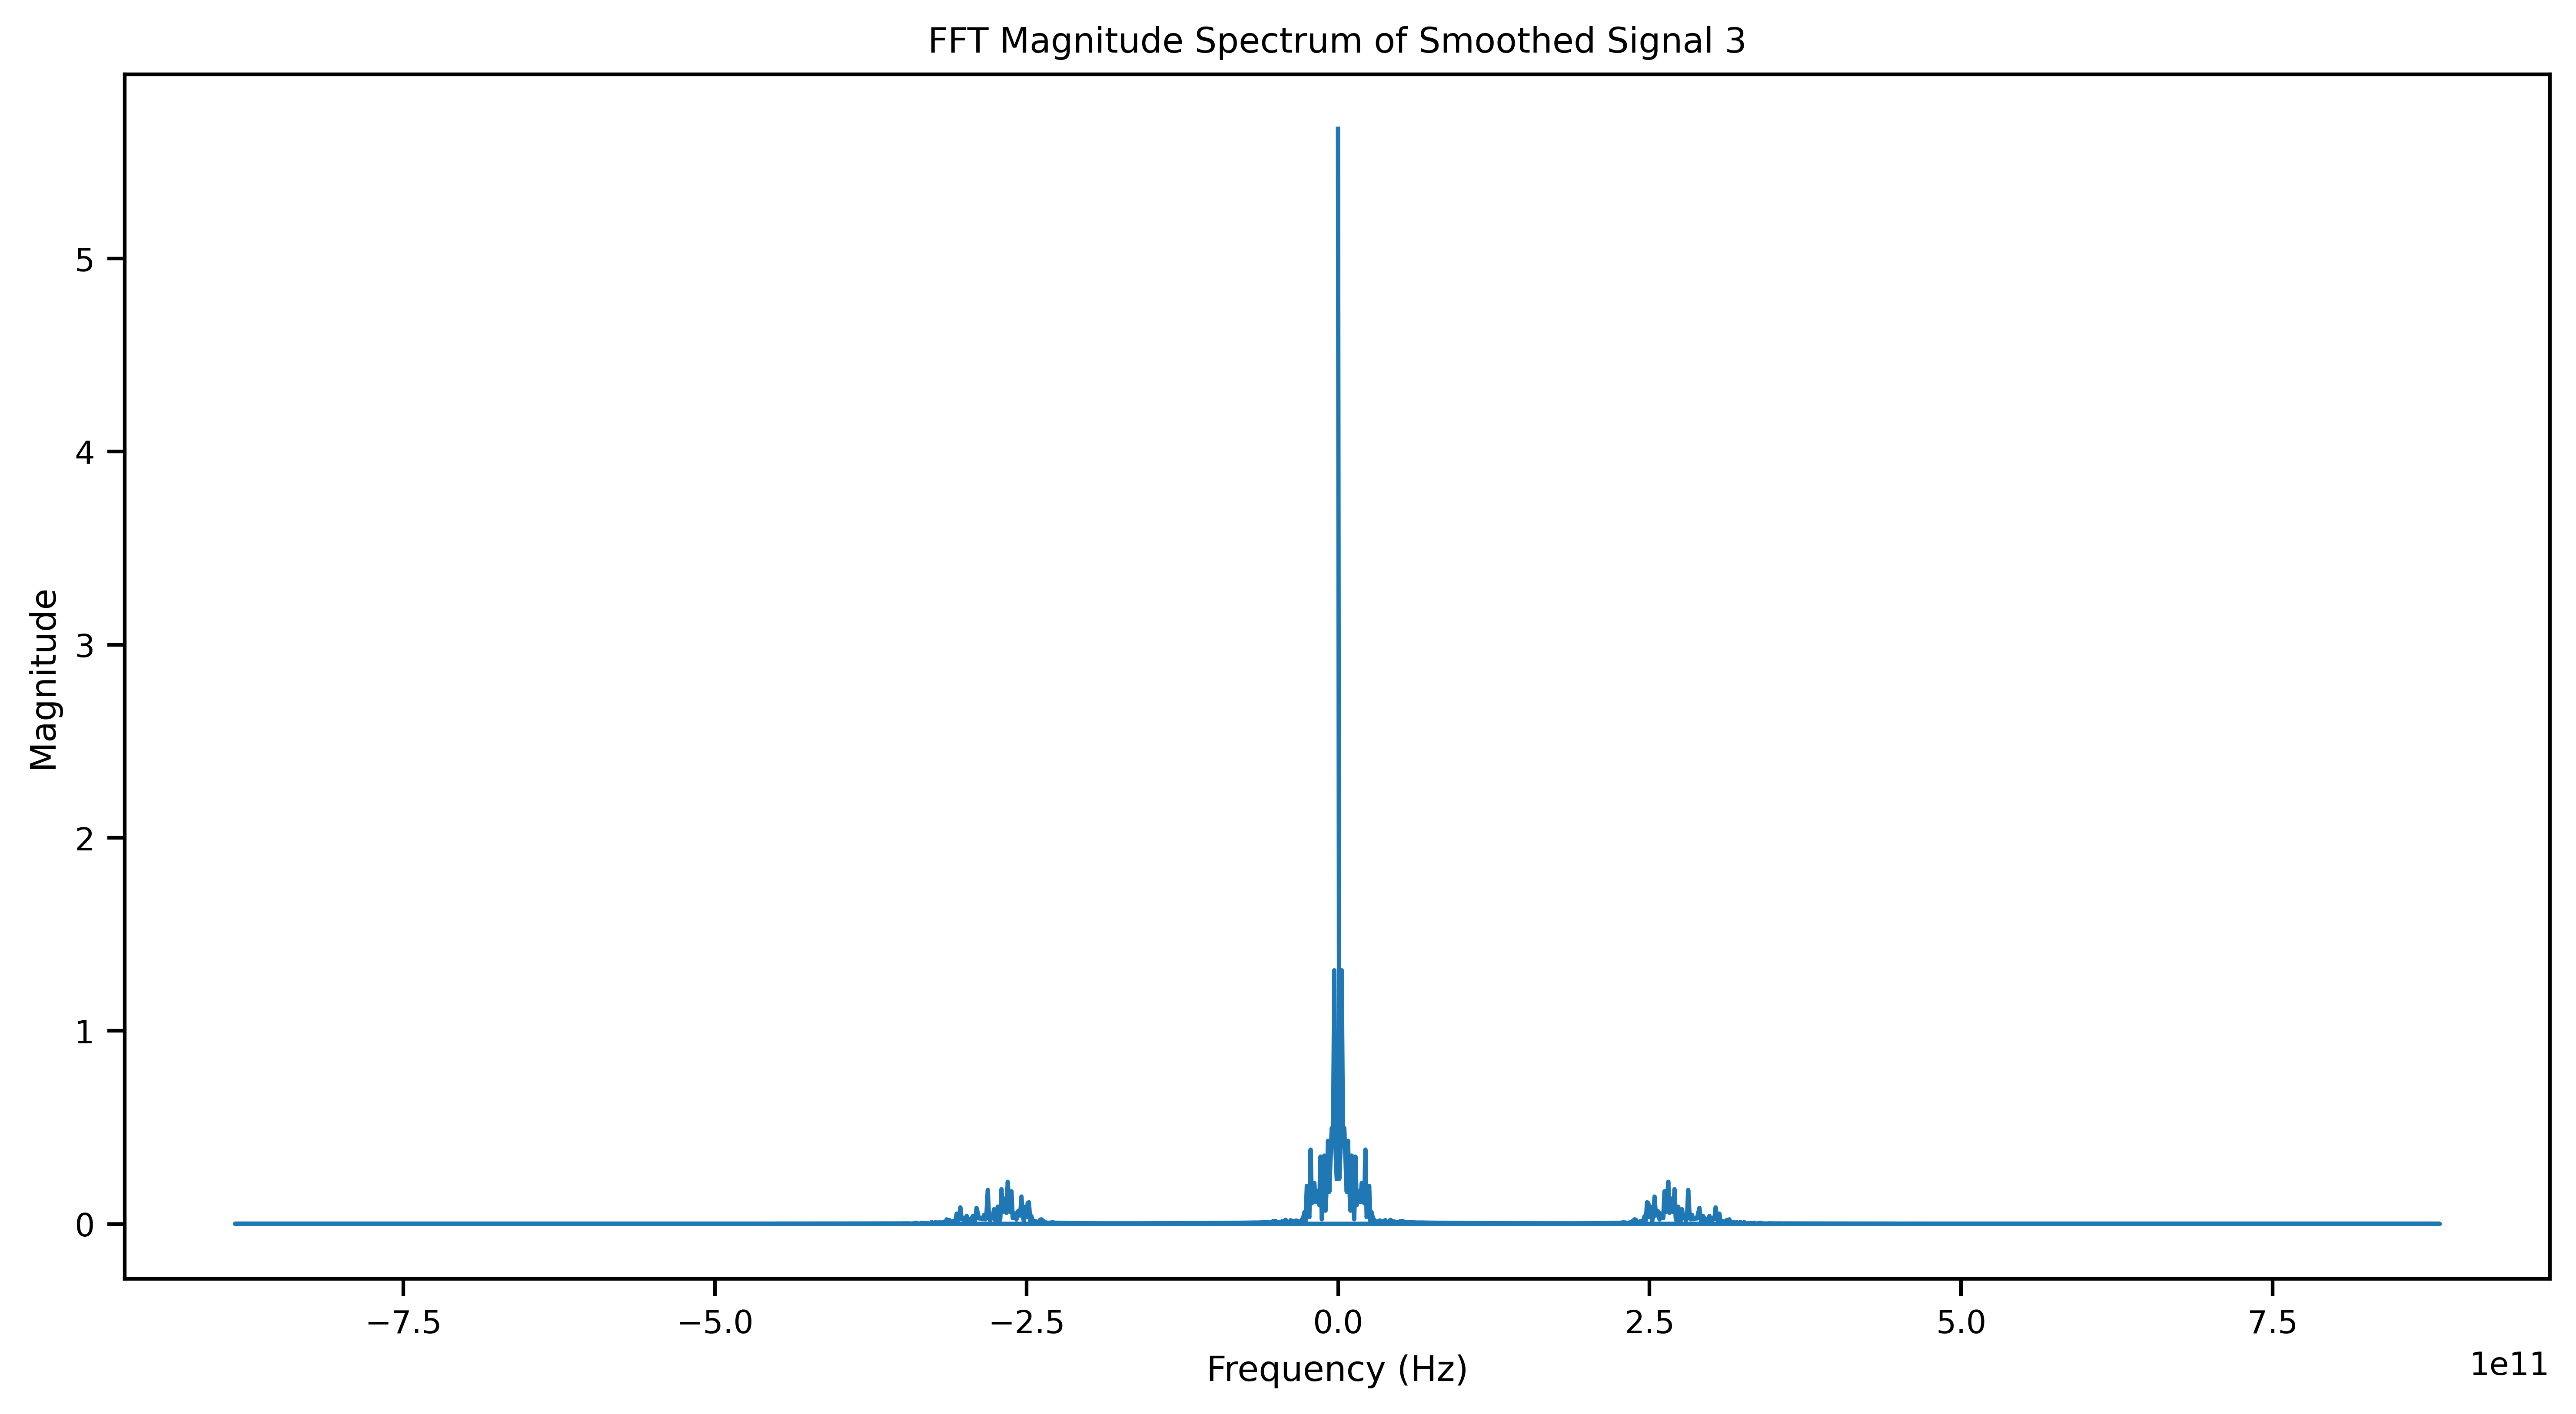

In [85]:
sampling_rate = len(mz2_region_AB) / 1e-9  # 采样率（Hz）

for i in range(signals_matrix.shape[0]):
    signal = signals_matrix[i]
    print(f"Signal {i+1}:")

    # 对信号进行平滑处理
    smoothed_signal = smooth_signal(signal, window_size=5, method='gaussian')
    
    # 计算自相关函数
    autocorr = compute_autocorrelation(smoothed_signal)
    
    # # 提取主要周期
    main_period = extract_period_from_autocorrelation(autocorr, sampling_rate)
    print(f"  Main Period from Autocorrelation: {main_period} seconds")
    
    #计算傅里叶变换
    fft_freq, magnitude = compute_fft(smoothed_signal, sampling_rate)
    
    # 可视化平滑信号
    plt.figure(figsize=(12, 6))
    plt.plot(signal, label='Original Signal')
    plt.plot(smoothed_signal, label='Smoothed Signal', linewidth=2)
    plt.title(f"Smoothed Signal {i+1}")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()
    
    # 可视化自相关函数
    plt.figure(figsize=(12, 6))
    plt.plot(autocorr)
    plt.title(f"Autocorrelation of Smoothed Signal {i+1}")
    plt.xlabel("Lag")
    plt.ylabel("Autocorrelation")
    plt.show()
    
    # 可视化傅里叶变换结果
    plt.figure(figsize=(12, 6))
    plt.plot(fft_freq, magnitude)
    plt.title(f"FFT Magnitude Spectrum of Smoothed Signal {i+1}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.show()